In [10]:
import random
import numpy as np
import pandas as pd
random.seed(3311791)
np.random.seed(3311791)
data = pd.read_csv('/kaggle/input/df-lemma-clean/df_lemma_dropped.csv').drop('H', axis=1)
df = data.copy()

!pip install xlsxwriter

In [11]:
imps = pd.read_csv('/kaggle/input/feature-importance/feature_importance_1991_to_2008.csv')
imps['Average Feature Importance'][0:10]

0    88.949856
1    15.575838
2     8.532342
3     4.996270
4     4.866200
5     2.700372
6     1.793331
7     0.652738
8     0.608602
9     0.560339
Name: Average Feature Importance, dtype: float64

In [12]:
accepted_imps = imps[(imps['Decision']=='Accepted') & (imps['Features'].str.contains('\+') | imps['Features'].str.contains('cluster_'))]
accepted_imps

,Features,Average Feature Importance,Standard Deviation Importance,Decision
9,anode+cathode,0.560339,0.896093,Accepted
24352,cluster_408,-0.026532,0.139120,Accepted
24403,cluster_221,-0.074065,0.078413,Accepted
24404,particle+separator,-0.074941,0.078415,Accepted


In [13]:
accepted_imps.reindex(accepted_imps['Average Feature Importance'].abs().sort_values(ascending=False).index).iloc[range(2)]
accepted_imps.reindex(accepted_imps['Average Feature Importance'].abs().sort_values(ascending=False).index)['Features'].iloc[range(2)]
list(accepted_imps.reindex(accepted_imps['Average Feature Importance'].abs().sort_values(ascending=False).index)['Features'])[0:2] 
list(accepted_imps.reindex(accepted_imps['Average Feature Importance'].abs().sort_values(ascending=False).index)['Features'].iloc[range(2)])

['anode+cathode', 'particle+separator']

In [14]:
accepted_imps.reindex(accepted_imps['Average Feature Importance'].sort_values(ascending=False).index)#.iloc[range(2)]


,Features,Average Feature Importance,Standard Deviation Importance,Decision
9,anode+cathode,0.560339,0.896093,Accepted
24352,cluster_408,-0.026532,0.139120,Accepted
24403,cluster_221,-0.074065,0.078413,Accepted
24404,particle+separator,-0.074941,0.078415,Accepted


In [15]:
list(accepted_imps.reindex(accepted_imps['Average Feature Importance'].abs().sort_values(ascending=False).index)['Features'].iloc[range(4)]) 

['anode+cathode', 'particle+separator', 'cluster_221', 'cluster_408']

In [16]:
accepted_imps_abs = accepted_imps.reindex(accepted_imps['Average Feature Importance'].abs().sort_values(ascending=False).index)
selected_features = accepted_imps_abs.iloc[0:2]
selected_features = selected_features.sort_values(by='Average Feature Importance', ascending=False)
selected_features_list = list(selected_features['Features'])
selected_features_list

['anode+cathode', 'particle+separator']

In [17]:
def find_accepted_sentences(file, tfidf_dummy, df_time_period, cluster_dict, n = None):
    results_df = pd.DataFrame()
    imps = pd.read_csv(file)
    accepted_imps = imps[(imps['Decision']=='Accepted') & (imps['Features'].str.contains('\+') | imps['Features'].str.contains('cluster_'))]
    #sort accepted_imps by absolut values
    accepted_imps_abs = accepted_imps.reindex(accepted_imps['Average Feature Importance'].abs().sort_values(ascending=False).index)

    if n is None: # get all accepted sentences
        selected_features = accepted_imps_abs
    elif len(n) == 1: # get top n sentences
        selected_features = accepted_imps_abs.iloc[0:n]
    else: # get sentences from indices 
        selected_features = accepted_imps_abs.iloc[n]
        
    selected_features = selected_features.sort_values(by='Average Feature Importance', ascending=False)
    selected_features_list = list(selected_features['Features'])

    for feature in selected_features_list:
        if feature.startswith('cluster_'):
            cluster_num = int(feature.split('_')[1])
            variables = cluster_dict[cluster_num]

            for i, var in enumerate(variables):
                sentences = process_sentences(feature=var, df_time_period=df_time_period, tfidf_dummy=tfidf_dummy)
                sentences['cluster'] = cluster_num
                results_df = pd.concat([results_df, sentences])
        else:
            sentences = process_sentences(feature=feature, df_time_period=df_time_period, tfidf_dummy=tfidf_dummy)
            sentences['cluster'] = '-'
            results_df = pd.concat([results_df, sentences])
            
    out = results_df[['cluster','Number.of.Forward.Citations', 'Year', 'Title', 'both_words_sentences']]
    return out

import re 
def process_sentences(feature, tfidf_dummy, df_time_period):#, start, stop):
        word_ngrams = feature.split('+')
        first_ngram = feature.split('+')[0].split()
        second_ngram = feature.split('+')[1].split()
        first_ngram_length = len(feature.split('+')[0].split())
        second_ngram_length = len(feature.split('+')[1].split())

        sentences = df_time_period[(tfidf_dummy[feature] == 1)]
        sentences = sentences[['Year', 'Text', 'Number.of.Forward.Citations', 'Title']]
        #select all sentences in which all words from both ngrams occur. Only the first 4 characters have to be present, such that plural forms etc. are included
        sentences['both_words_sentences'] = sentences['Text'].apply(lambda x: ' '.join([sent+'.' for sent in re.split('[.:;?!]', x) if all(word[0:4] in sent.lower() for word in first_ngram) and all(word[0:4] in sent.lower() for word in second_ngram)]))

        #Set the index to the feature name
        sentences.index = [feature] * len(sentences)
        return sentences
    
def save_as_xlsx(results, filename='Qualitative Analysis Sheets'):
    writer = pd.ExcelWriter(f'/kaggle/working/{filename}.xlsx', engine='xlsxwriter') # Accepted Co-Occurrences
    sheet_names = ['1920 - 1990', '1991 - 2008', '2009 - 2016', '2017 - 2023']
    
    for i, sheet_name in enumerate(sheet_names):
        results[i].to_excel(writer, sheet_name=sheet_name)

    workbook = writer.book
    wrap_format = workbook.add_format({'text_wrap': True})
    
    for sheet_name in sheet_names: 
        worksheet = writer.sheets[sheet_name]
        worksheet.set_column('A:Z', 20, wrap_format)
    writer.close()


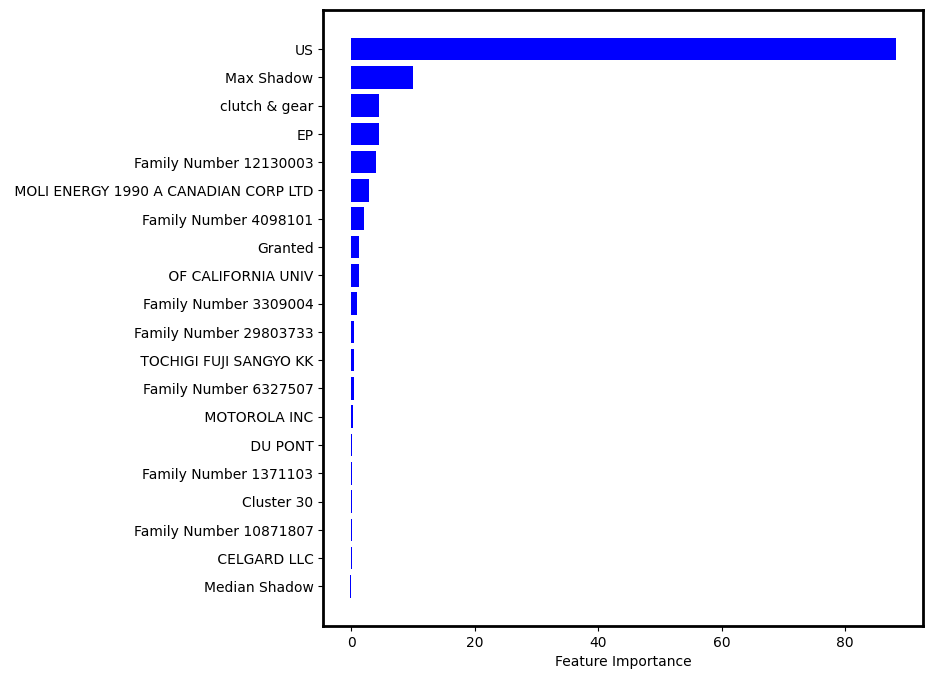

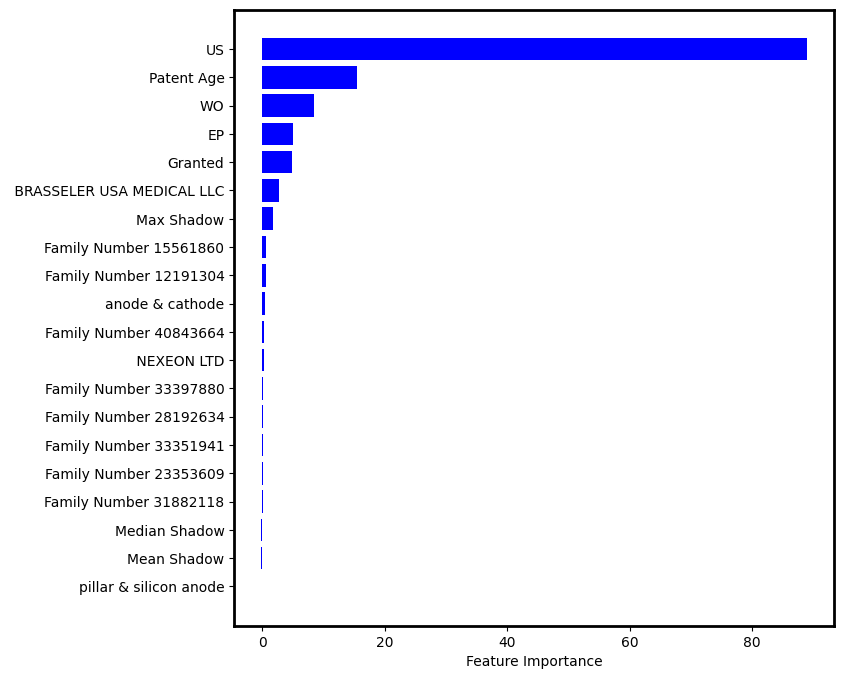

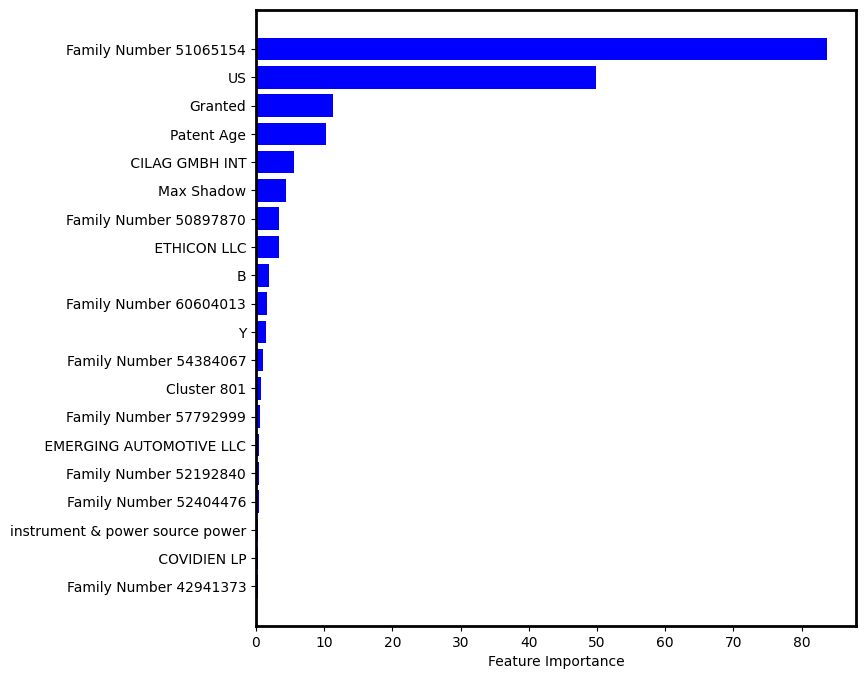

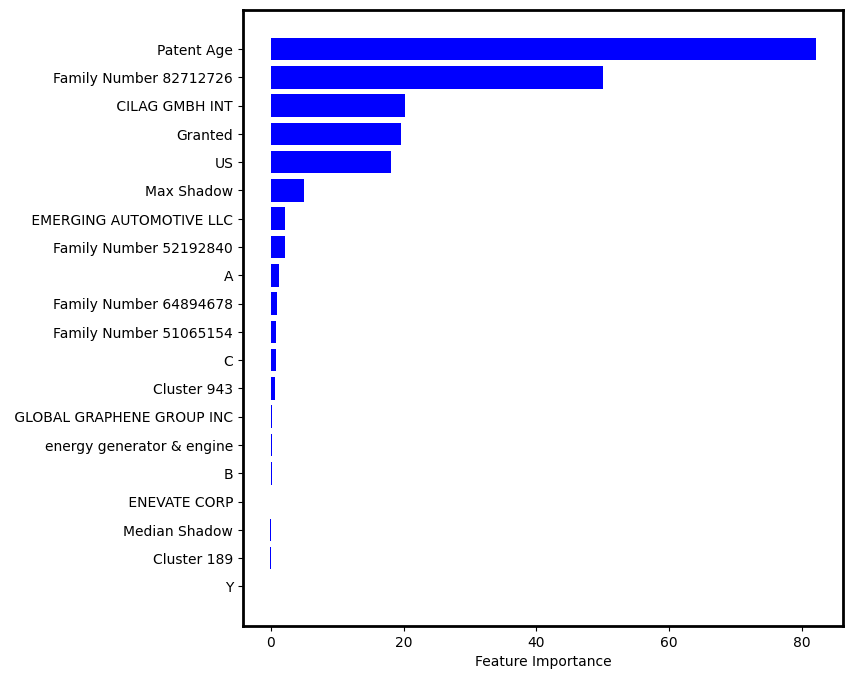

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

#mpl.rcParams['font.family'] = 'Avenir'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 2

time_periods = [(float(min(df['Year'])), 1990), (1991, 2008), (2009, 2016), (2017, float(max(df['Year'])))]

for (start, stop) in time_periods:
    imps = pd.read_csv(f'/kaggle/input/feature-importance/feature_importance_{start}_to_{stop}.csv')
    accepted_imps = imps#[(imps['Decision']=='Accepted') & (imps['Features'].str.contains('\+') | imps['Features'].str.contains('cluster_'))]
    #prettify variable names
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('+', ' & ')
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('cluster', 'Cluster')
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('Country.Code_', '')
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('Probable.Patent.Assignee', '')
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('.', ' ')
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('age_scaled', 'Age')
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('Grant_dummy', 'Granted')
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('_', ' ')
    
    accepted_imps_abs = accepted_imps.reindex(accepted_imps['Average Feature Importance'].abs().sort_values(ascending=False).index).head(20)

    plt.figure(figsize=(10, 8))  # Specify the figure size
    plt.subplots_adjust(left=0.3)  # Adjust the left margin
    plt.barh(accepted_imps_abs['Features'], accepted_imps_abs['Average Feature Importance'], color='blue')
    #plt.title(f'Feature Importances for {int(start)} - {int(stop)}')
    plt.xlabel('Feature Importance')
    plt.gca().invert_yaxis()
    
    # Save the plot to a file
    plt.savefig(f'feature_importance_{int(start)}_to_{int(stop)}.png', bbox_inches='tight')
    plt.show()  # Close the figure


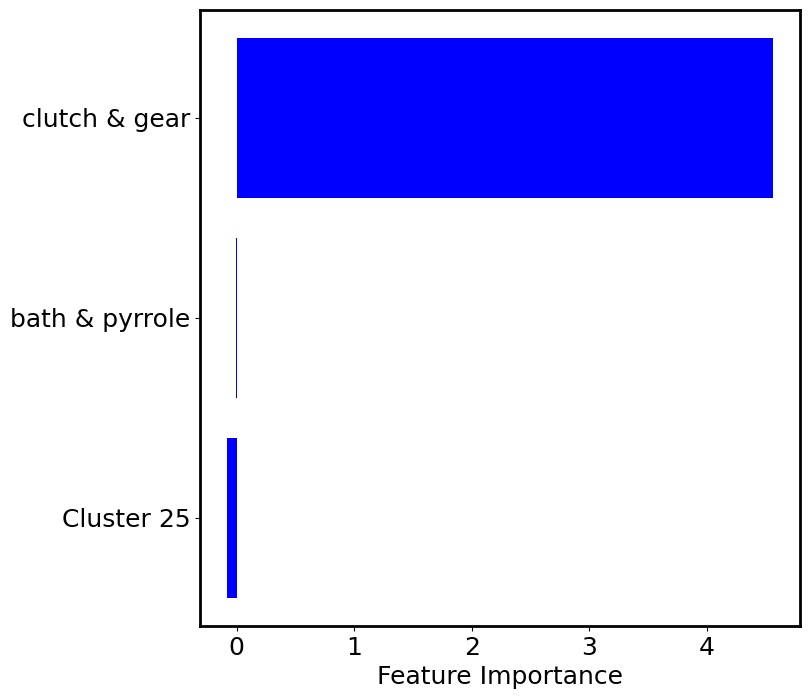

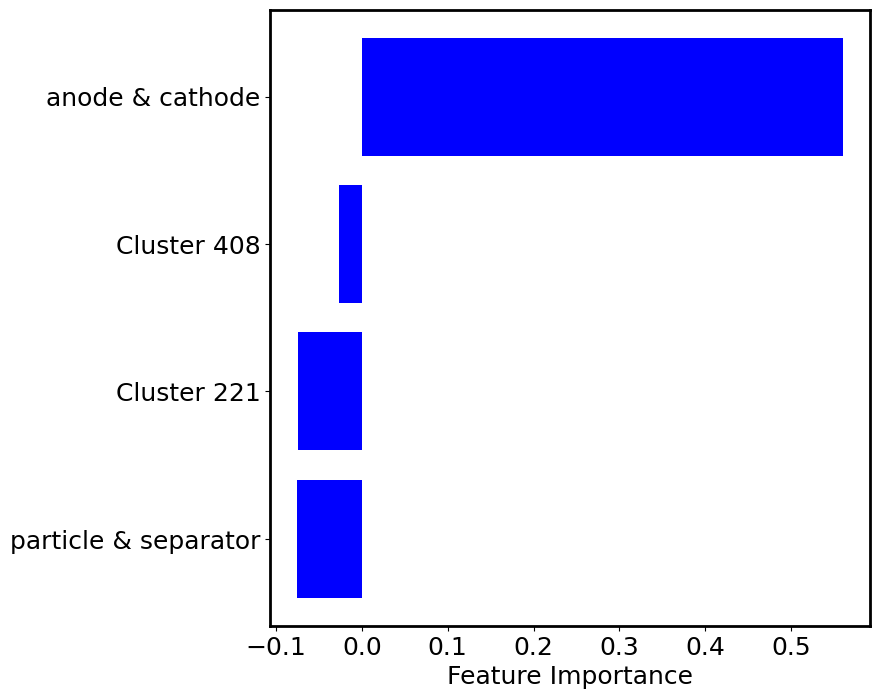

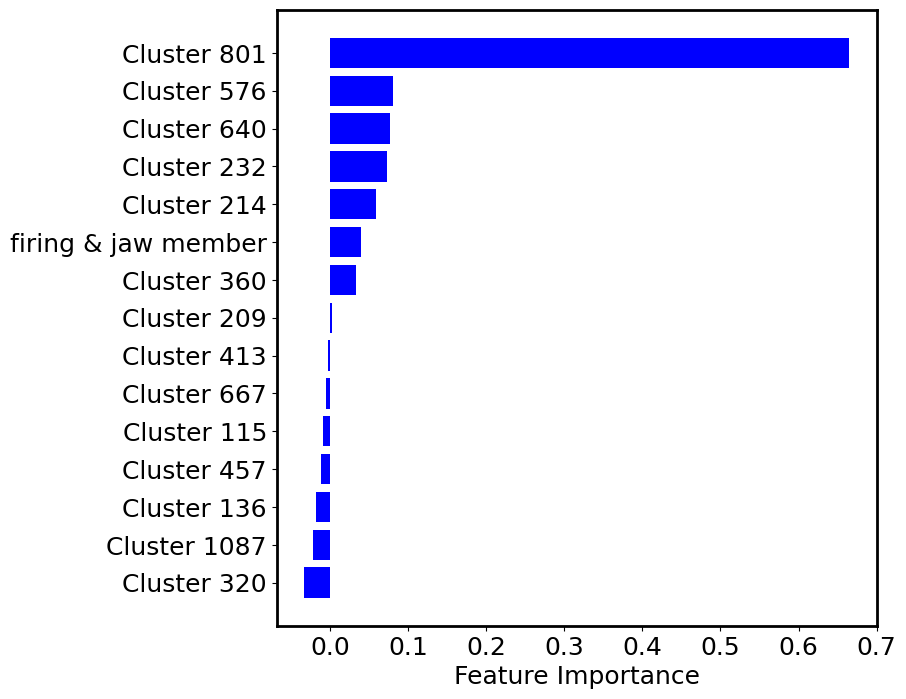

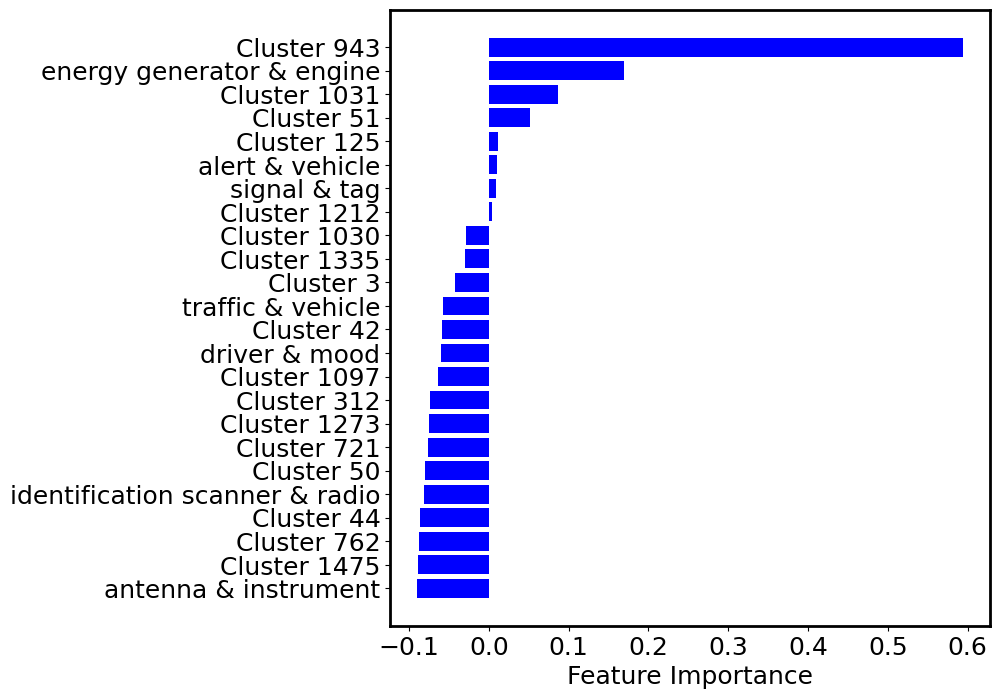

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

#mpl.rcParams['font.family'] = 'Avenir'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2

time_periods = [(float(min(df['Year'])), 1990), (1991, 2008), (2009, 2016), (2017, float(max(df['Year'])))]

for (start, stop) in time_periods:
    imps = pd.read_csv(f'/kaggle/input/feature-importance/feature_importance_{start}_to_{stop}.csv')
    accepted_imps = imps[(imps['Decision']=='Accepted') & (imps['Features'].str.contains('\+') | imps['Features'].str.contains('cluster_'))]
    #prettify variable names
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('+', ' & ')
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('_', ' ')
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('scaled', '')
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('cluster', 'Cluster')
    
    plt.figure(figsize=(10, 8))  # Specify the figure size
    plt.subplots_adjust(left=0.3)  # Adjust the left margin
    plt.barh(accepted_imps['Features'], accepted_imps['Average Feature Importance'], color='blue')
    #plt.title(f'Feature Importances for {int(start)} - {int(stop)}')
    plt.xlabel('Feature Importance')
    plt.gca().invert_yaxis()
    
    # Save the plot to a file
    plt.savefig(f'feature_importance_{int(start)}_to_{int(stop)}.png', bbox_inches='tight')
    plt.show()  # Close the figure


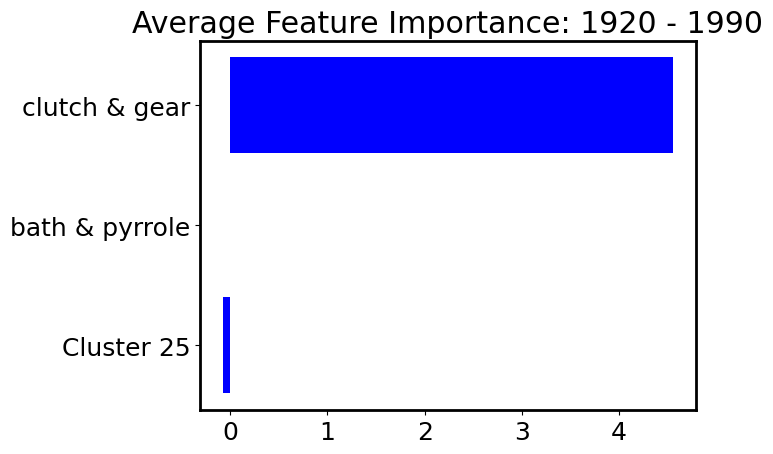

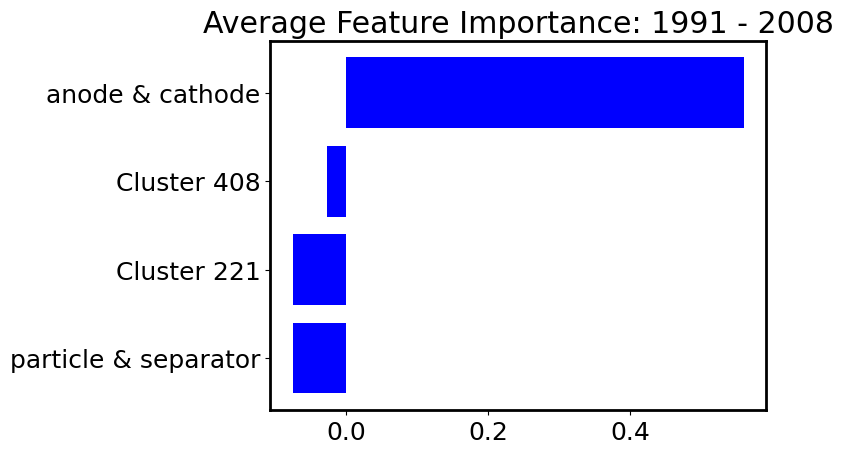

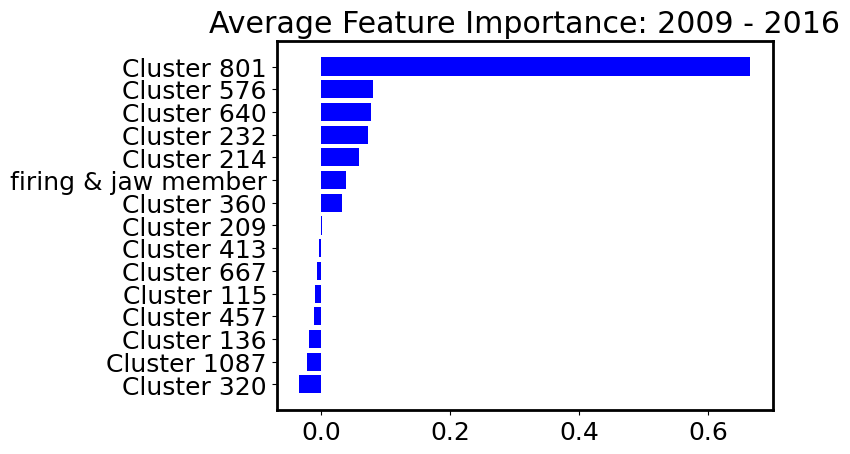

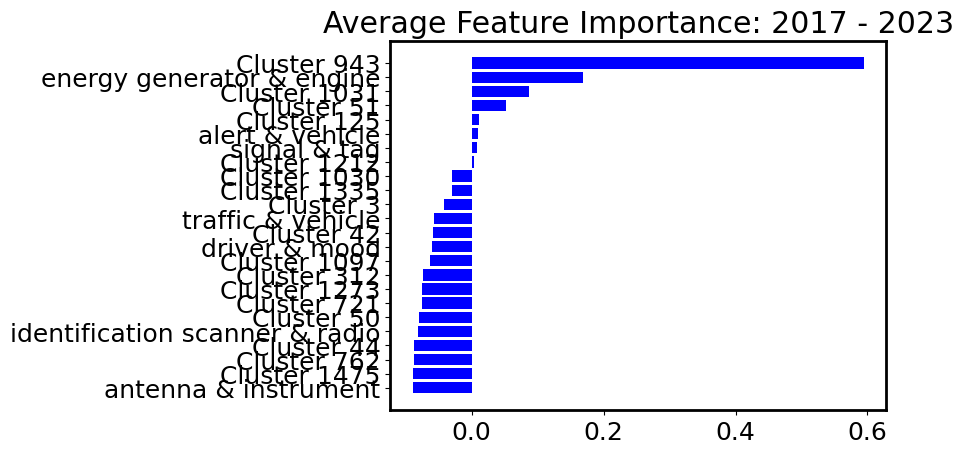

In [10]:
import matplotlib.pyplot as plt
time_periods = [(float(min(df['Year'])), 1990), (1991, 2008), (2009, 2016), (2017, float(max(df['Year'])))] 

for (start, stop) in time_periods:
    imps = pd.read_csv(f'/kaggle/input/feature-importance/feature_importance_{start}_to_{stop}.csv')
    accepted_imps = imps[(imps['Decision']=='Accepted') & (imps['Features'].str.contains('\+') | imps['Features'].str.contains('cluster_'))]
    #prettify variable names
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('+', ' & ')
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('_', ' ')
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('scaled', '')
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('cluster', 'Cluster')
    
    #colors = ['tab:blue', 'tab:blue', 'red', 'tab:blue', 'tab:blue']
    plt.barh(accepted_imps['Features'], accepted_imps['Average Feature Importance'], color='blue')#color=colors)
#     plt.xlabel('Average Feature Importance', fontsize=24)
    #plt.ylabel('Features', fontsize=24)
    #plt.title('Feature Importance', fontsize=26)
#     plt.xticks(fontsize=18)
#     plt.yticks(fontsize=24)
    plt.title(f'Average Feature Importance: {int(start)} - {int(stop)}')
    plt.gca().invert_yaxis()
    plt.savefig(f'feature_importance_{int(start)}_to_{int(stop)}.png')
    plt.show()


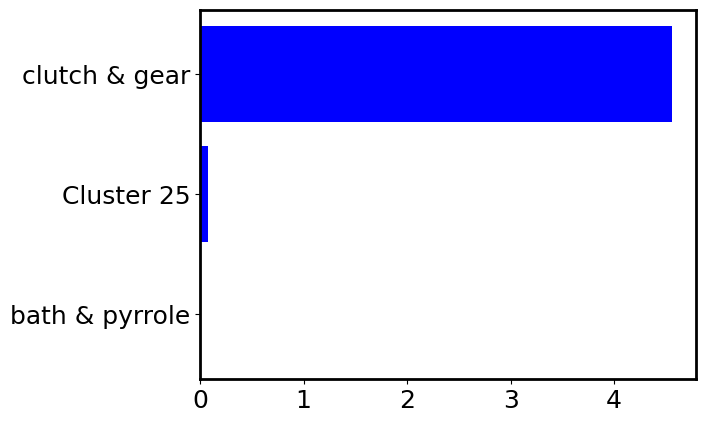

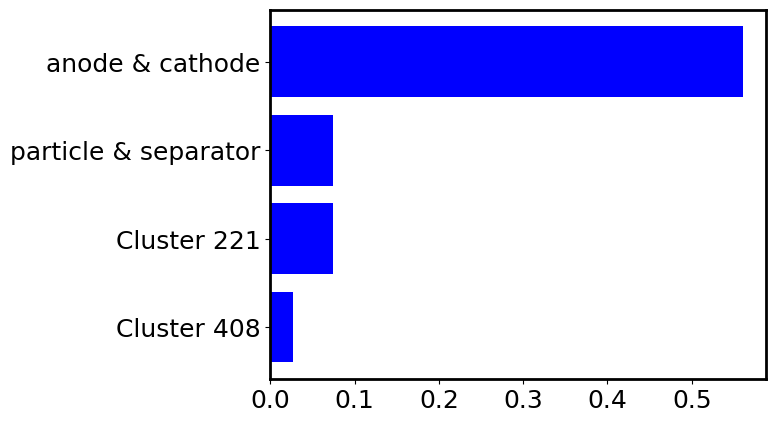

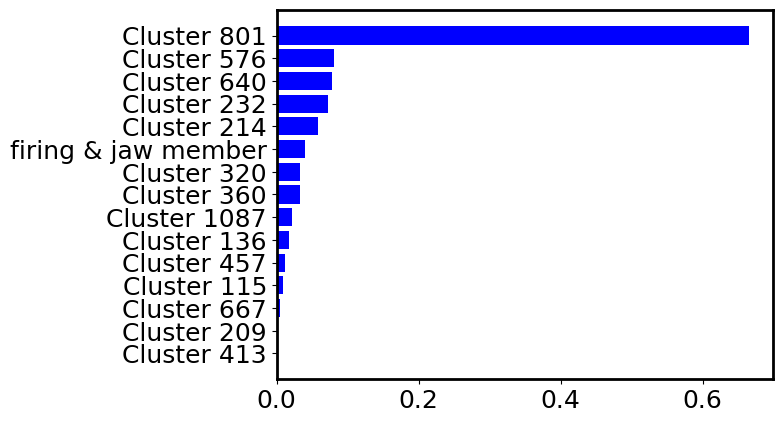

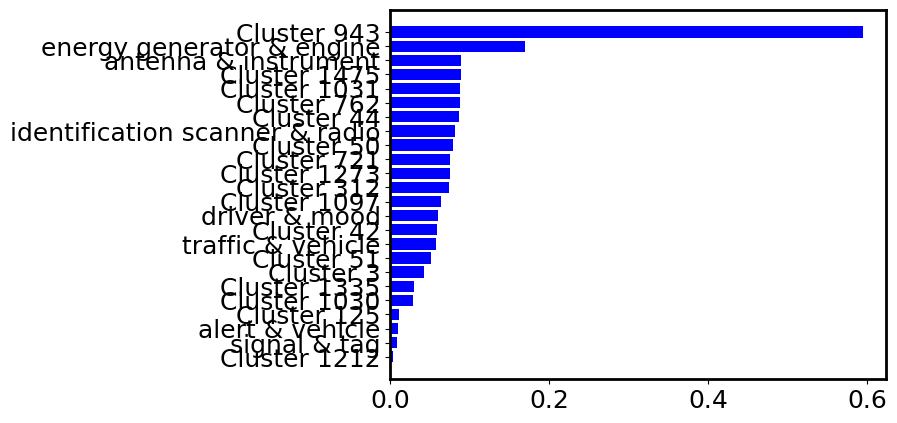

In [11]:
for (start, stop) in time_periods:
    imps = pd.read_csv(f'/kaggle/input/feature-importance/feature_importance_{start}_to_{stop}.csv')
    accepted_imps = imps[(imps['Decision']=='Accepted') & (imps['Features'].str.contains('\+') | imps['Features'].str.contains('cluster_'))]
    #prettify variable names
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('+', ' & ')
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('_', ' ')
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('scaled', '')
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('cluster', 'Cluster')
    
    accepted_imps_abs = accepted_imps.copy()
    accepted_imps_abs['Average Feature Importance'] = accepted_imps_abs['Average Feature Importance'].abs()
    accepted_imps_abs = accepted_imps_abs.sort_values(by='Average Feature Importance', ascending=False)
    
    #colors = ['tab:blue', 'tab:blue', 'red', 'tab:blue', 'tab:blue']
    plt.barh(accepted_imps_abs['Features'], accepted_imps_abs['Average Feature Importance'], color='blue')#color=colors)
#     plt.xlabel('Average Feature Importance', fontsize=24)
    #plt.ylabel('Features', fontsize=24)
    #plt.title('Feature Importance', fontsize=26)
#     plt.xticks(fontsize=18)
#     plt.yticks(fontsize=24)
    plt.gca().invert_yaxis()
    plt.show()

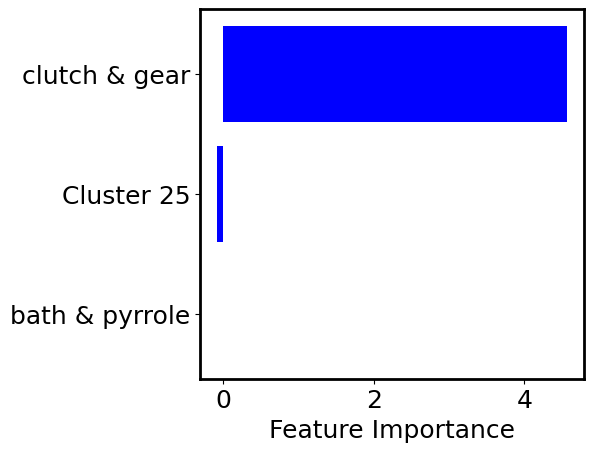

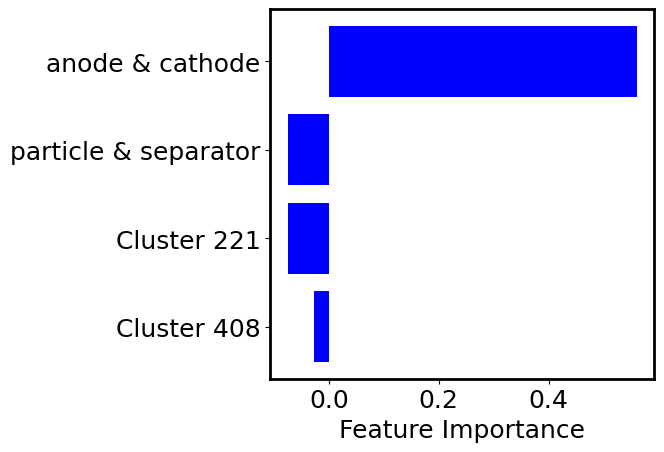

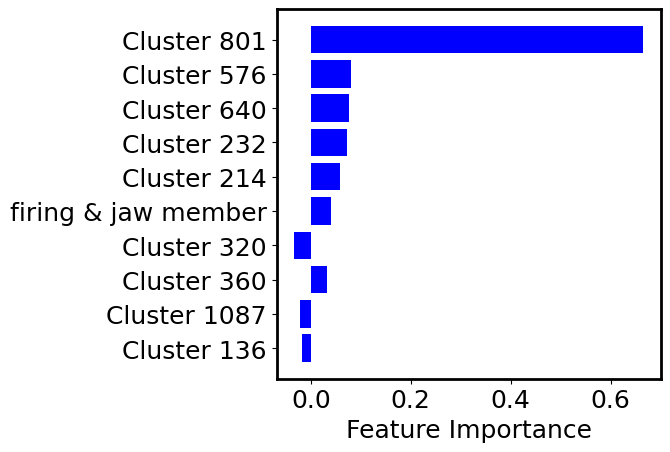

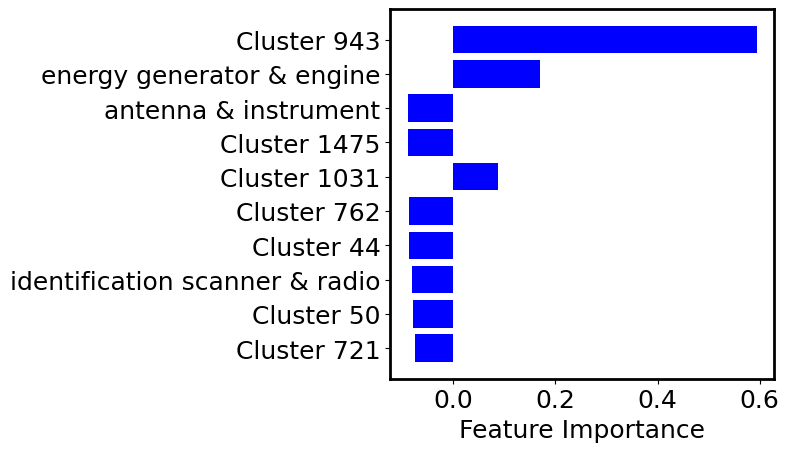

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2

time_periods = [(float(min(df['Year'])), 1990), (1991, 2008), (2009, 2016), (2017, float(max(df['Year'])))]

for (start, stop) in time_periods:
    imps = pd.read_csv(f'/kaggle/input/feature-importance/feature_importance_{start}_to_{stop}.csv')
    accepted_imps = imps[(imps['Decision']=='Accepted') & (imps['Features'].str.contains('\+') | imps['Features'].str.contains('cluster_'))]
    
    #prettify variable names
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('+', ' & ')
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('_', ' ')
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('scaled', '')
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('cluster', 'Cluster')
    
    # Sort by absolute 'Average Feature Importance' and select top 10
    accepted_imps_abs = accepted_imps.reindex(accepted_imps['Average Feature Importance'].abs().sort_values(ascending=False).index).head(10)
    
 #   plt.figure(figsize=(10, 8))  # Specify the figure size
    plt.subplots_adjust(left=0.3)  # Adjust the left margin
    plt.barh(accepted_imps_abs['Features'], accepted_imps_abs['Average Feature Importance'], color='blue')
    plt.xlabel('Feature Importance')
    plt.gca().invert_yaxis()
    
    # Save the plot to a file
    plt.savefig(f'feature_importance_{int(start)}_to_{int(stop)}.png', bbox_inches='tight')
    plt.show()  # Close the figure


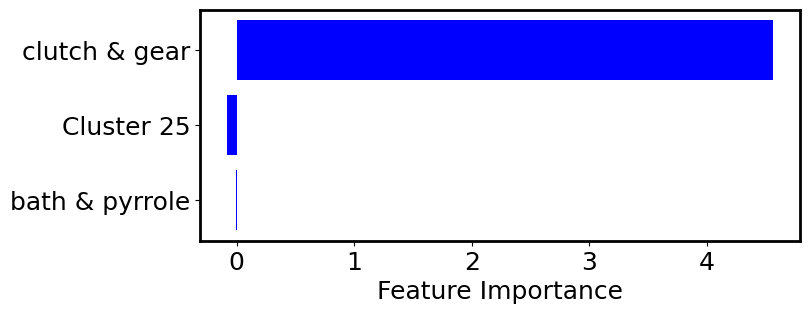

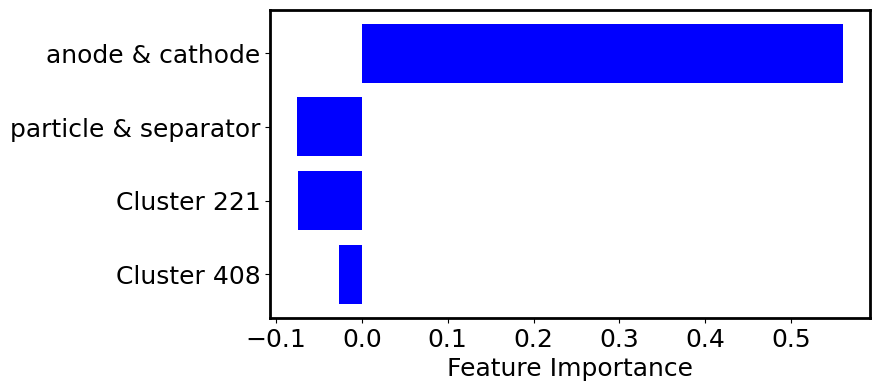

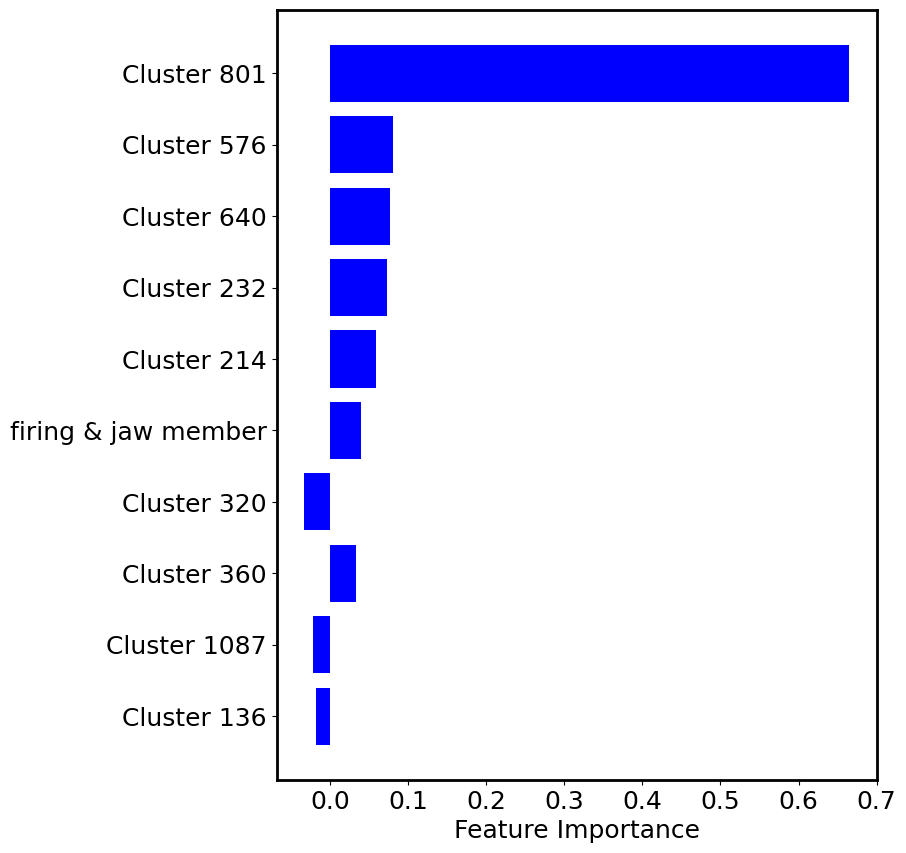

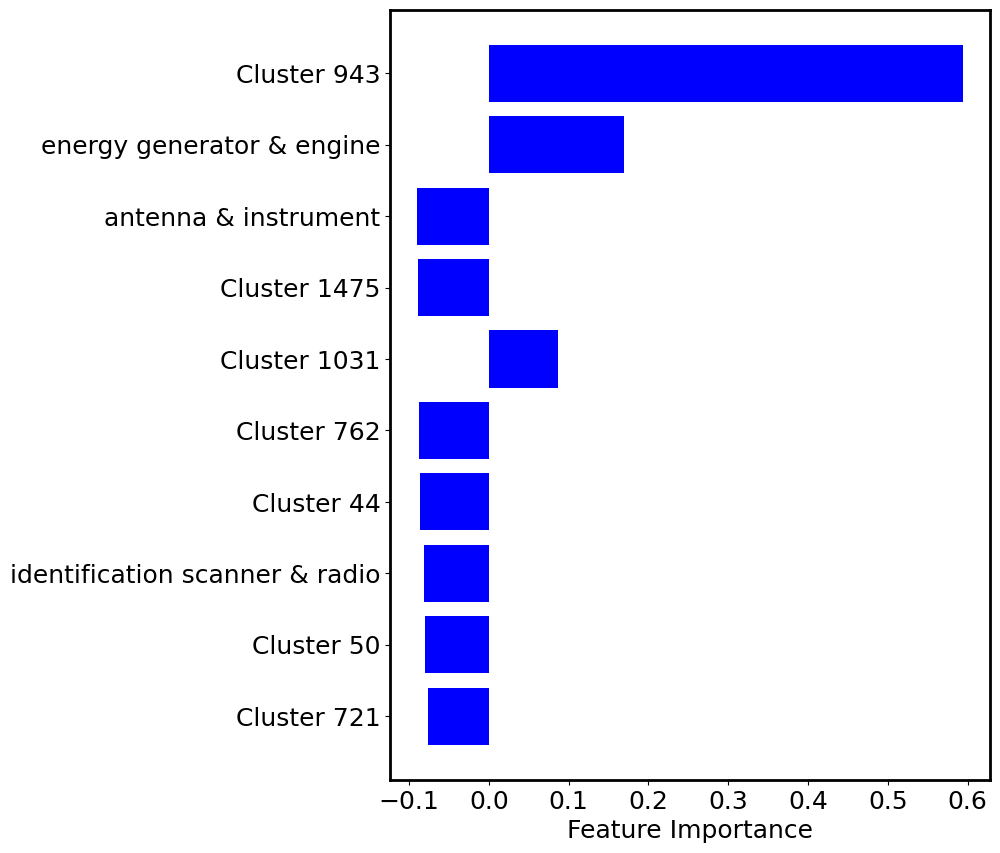

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2

time_periods = [(float(min(df['Year'])), 1990), (1991, 2008), (2009, 2016), (2017, float(max(df['Year'])))]

for (start, stop) in time_periods:
    imps = pd.read_csv(f'/kaggle/input/feature-importance/feature_importance_{start}_to_{stop}.csv')
    accepted_imps = imps[(imps['Decision']=='Accepted') & (imps['Features'].str.contains('\+') | imps['Features'].str.contains('cluster_'))]
    
    #prettify variable names
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('+', ' & ')
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('_', ' ')
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('scaled', '')
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('cluster', 'Cluster')
    
    # Sort by absolute 'Average Feature Importance' and select top 10
    accepted_imps_abs = accepted_imps.reindex(accepted_imps['Average Feature Importance'].abs().sort_values(ascending=False).index).head(10)
    
    # Dynamically set the figure height based on the number of features
    plt.figure(figsize=(10, len(accepted_imps_abs)))  # Specify the figure size
    
    plt.subplots_adjust(left=0.3)  # Adjust the left margin
    plt.barh(accepted_imps_abs['Features'], accepted_imps_abs['Average Feature Importance'], color='blue')
    plt.xlabel('Feature Importance')
    plt.gca().invert_yaxis()
    
    # Save the plot to a file
    plt.savefig(f'feature_importance_{int(start)}_to_{int(stop)}.png', bbox_inches='tight')
    plt.show()  # Close the figure


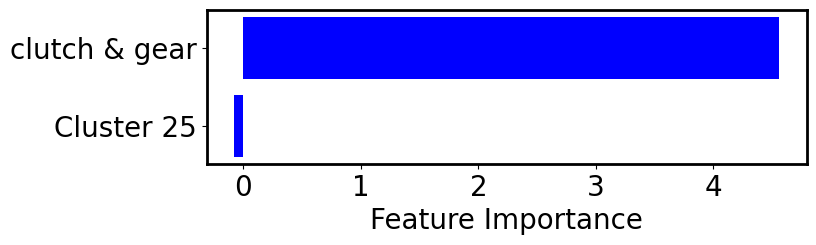

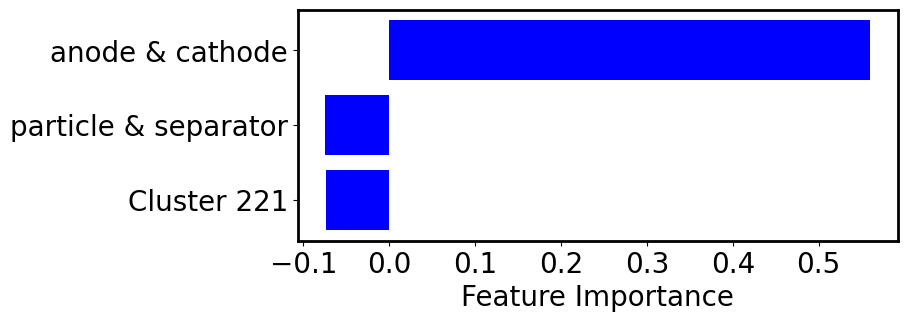

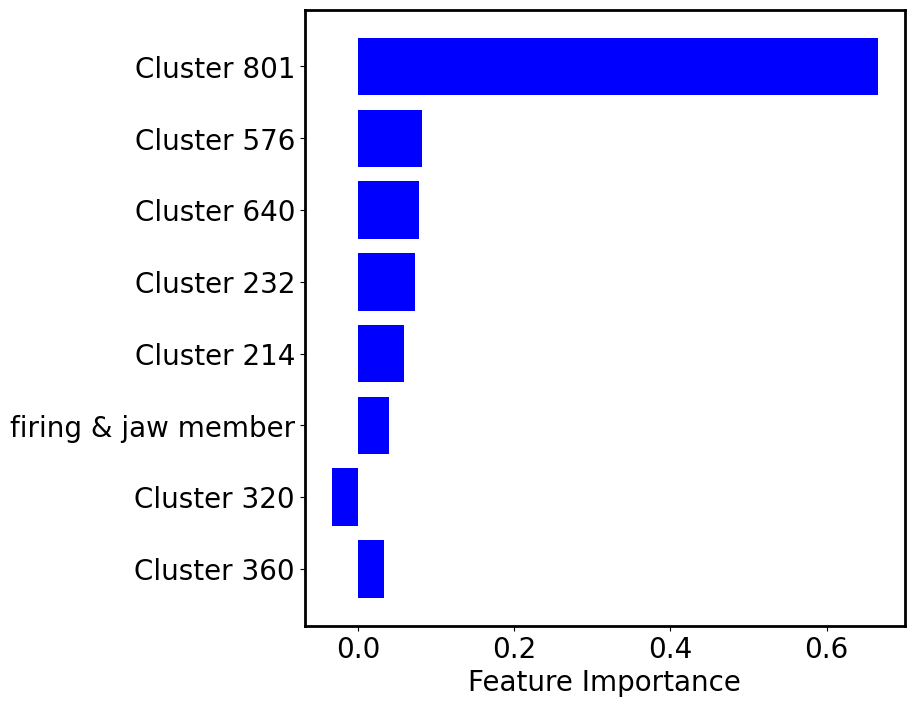

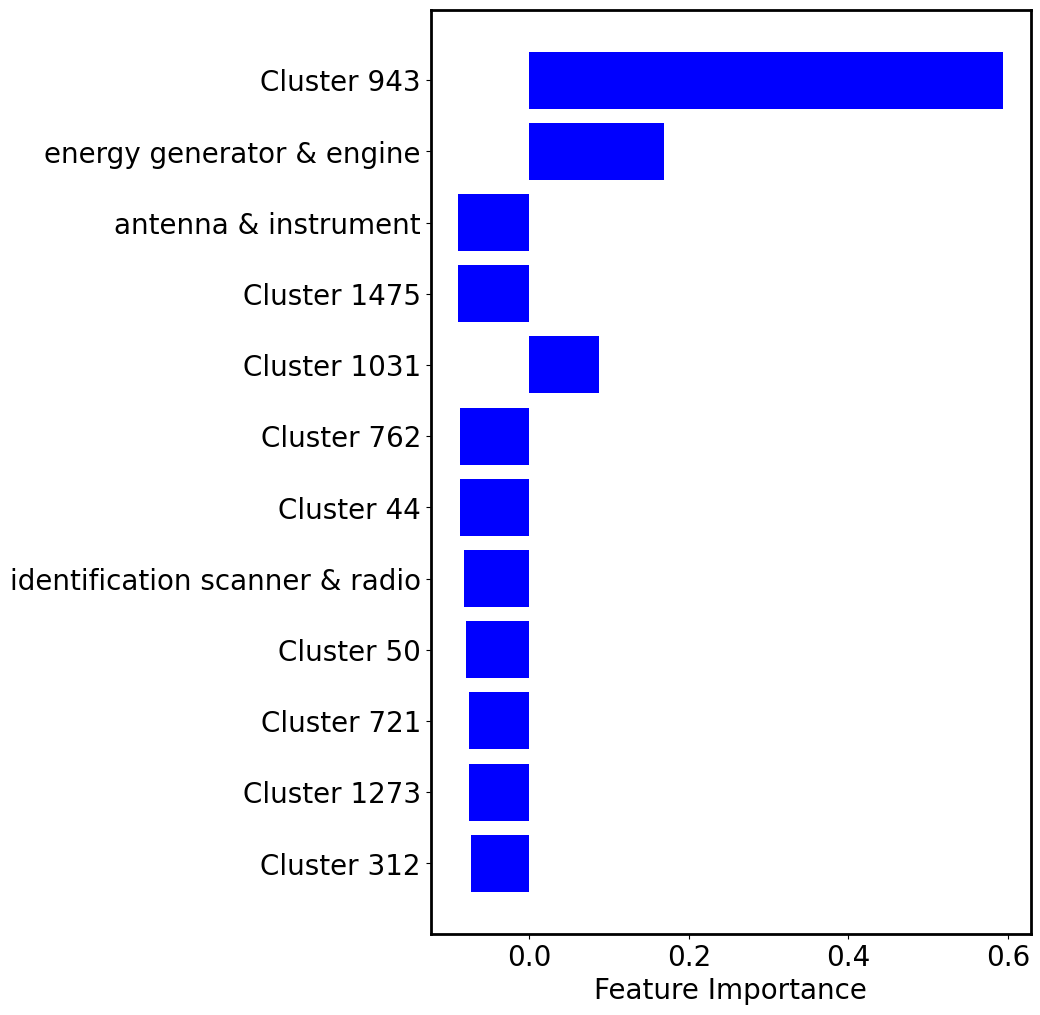

In [14]:
#keep_top_n
keep_top_n = [2,3,8,12]

plt.rcParams['font.size'] = 20
plt.rcParams['axes.linewidth'] = 2

time_periods = [(float(min(df['Year'])), 1990), (1991, 2008), (2009, 2016), (2017, float(max(df['Year'])))]

for i,(start, stop) in enumerate(time_periods):
    imps = pd.read_csv(f'/kaggle/input/feature-importance/feature_importance_{start}_to_{stop}.csv')
    accepted_imps = imps[(imps['Decision']=='Accepted') & (imps['Features'].str.contains('\+') | imps['Features'].str.contains('cluster_'))]
    
    #prettify variable names
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('+', ' & ')
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('_', ' ')
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('scaled', '')
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('cluster', 'Cluster')
    
    # Sort by absolute 'Average Feature Importance' and select top 10
    accepted_imps_abs = accepted_imps.reindex(accepted_imps['Average Feature Importance'].abs().sort_values(ascending=False).index).head(keep_top_n[i])
    
    # Dynamically set the figure height based on the number of features
    plt.figure(figsize=(10, len(accepted_imps_abs)))  # Specify the figure size
    
    plt.subplots_adjust(left=0.3)  # Adjust the left margin
    plt.barh(accepted_imps_abs['Features'], accepted_imps_abs['Average Feature Importance'], color='blue')
    plt.xlabel('Feature Importance')
    plt.gca().invert_yaxis()
    
    # Save the plot to a file
    plt.savefig(f'feature_importance_{int(start)}_to_{int(stop)}.png', bbox_inches='tight')
    plt.show()  # Close the figure


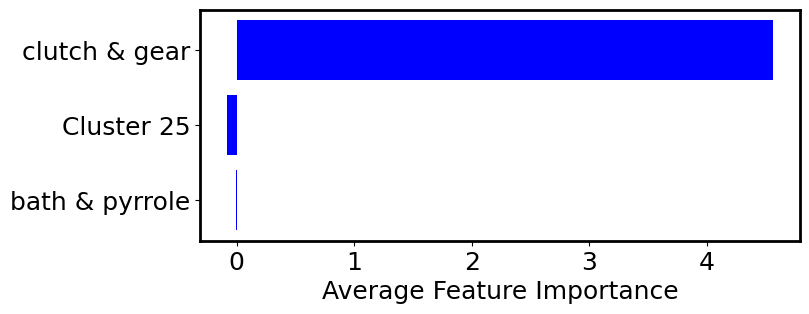

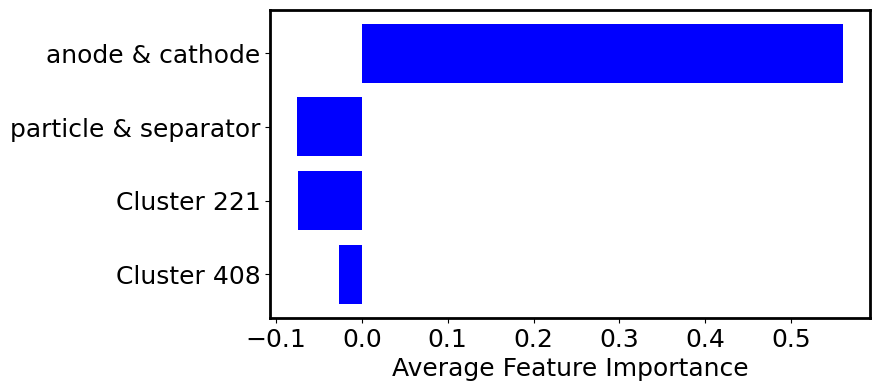

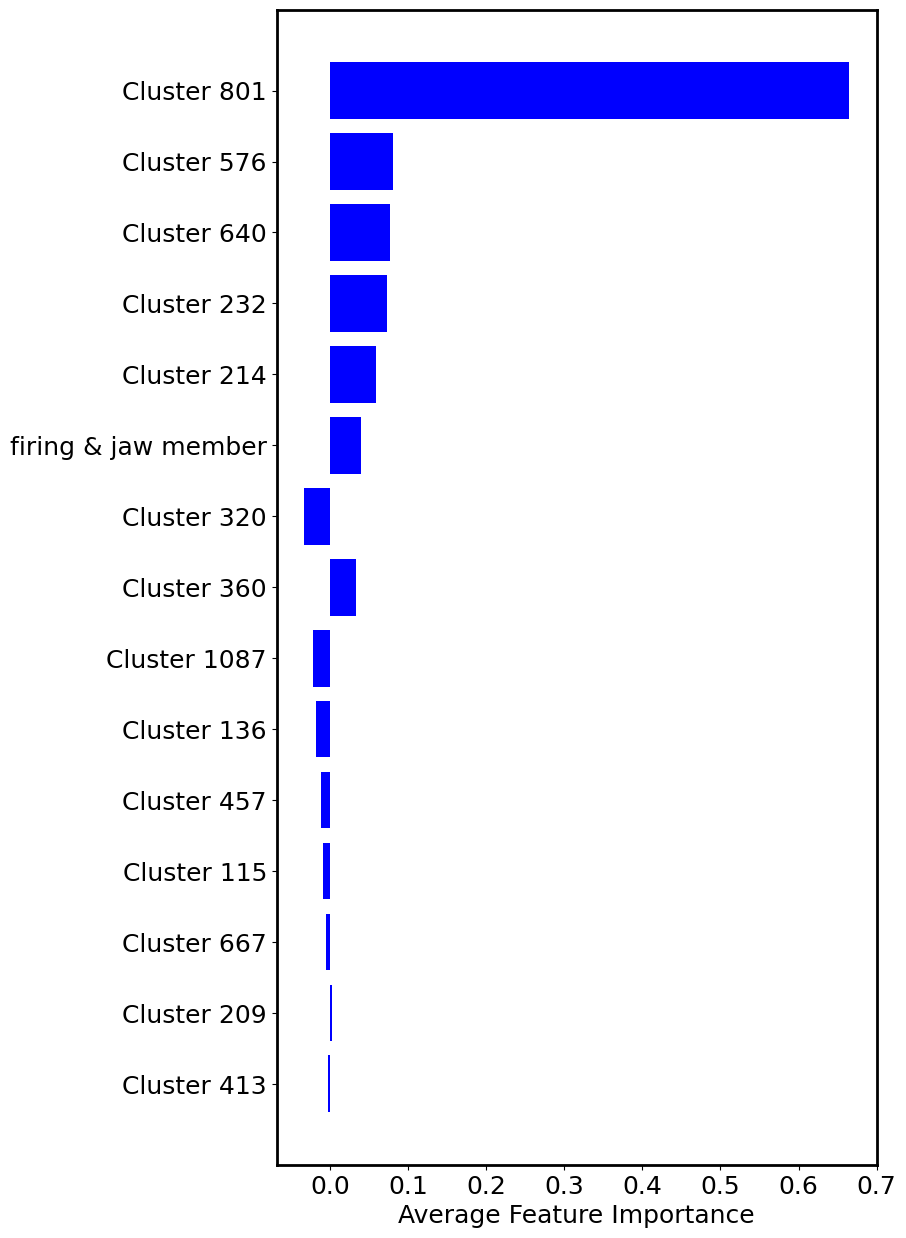

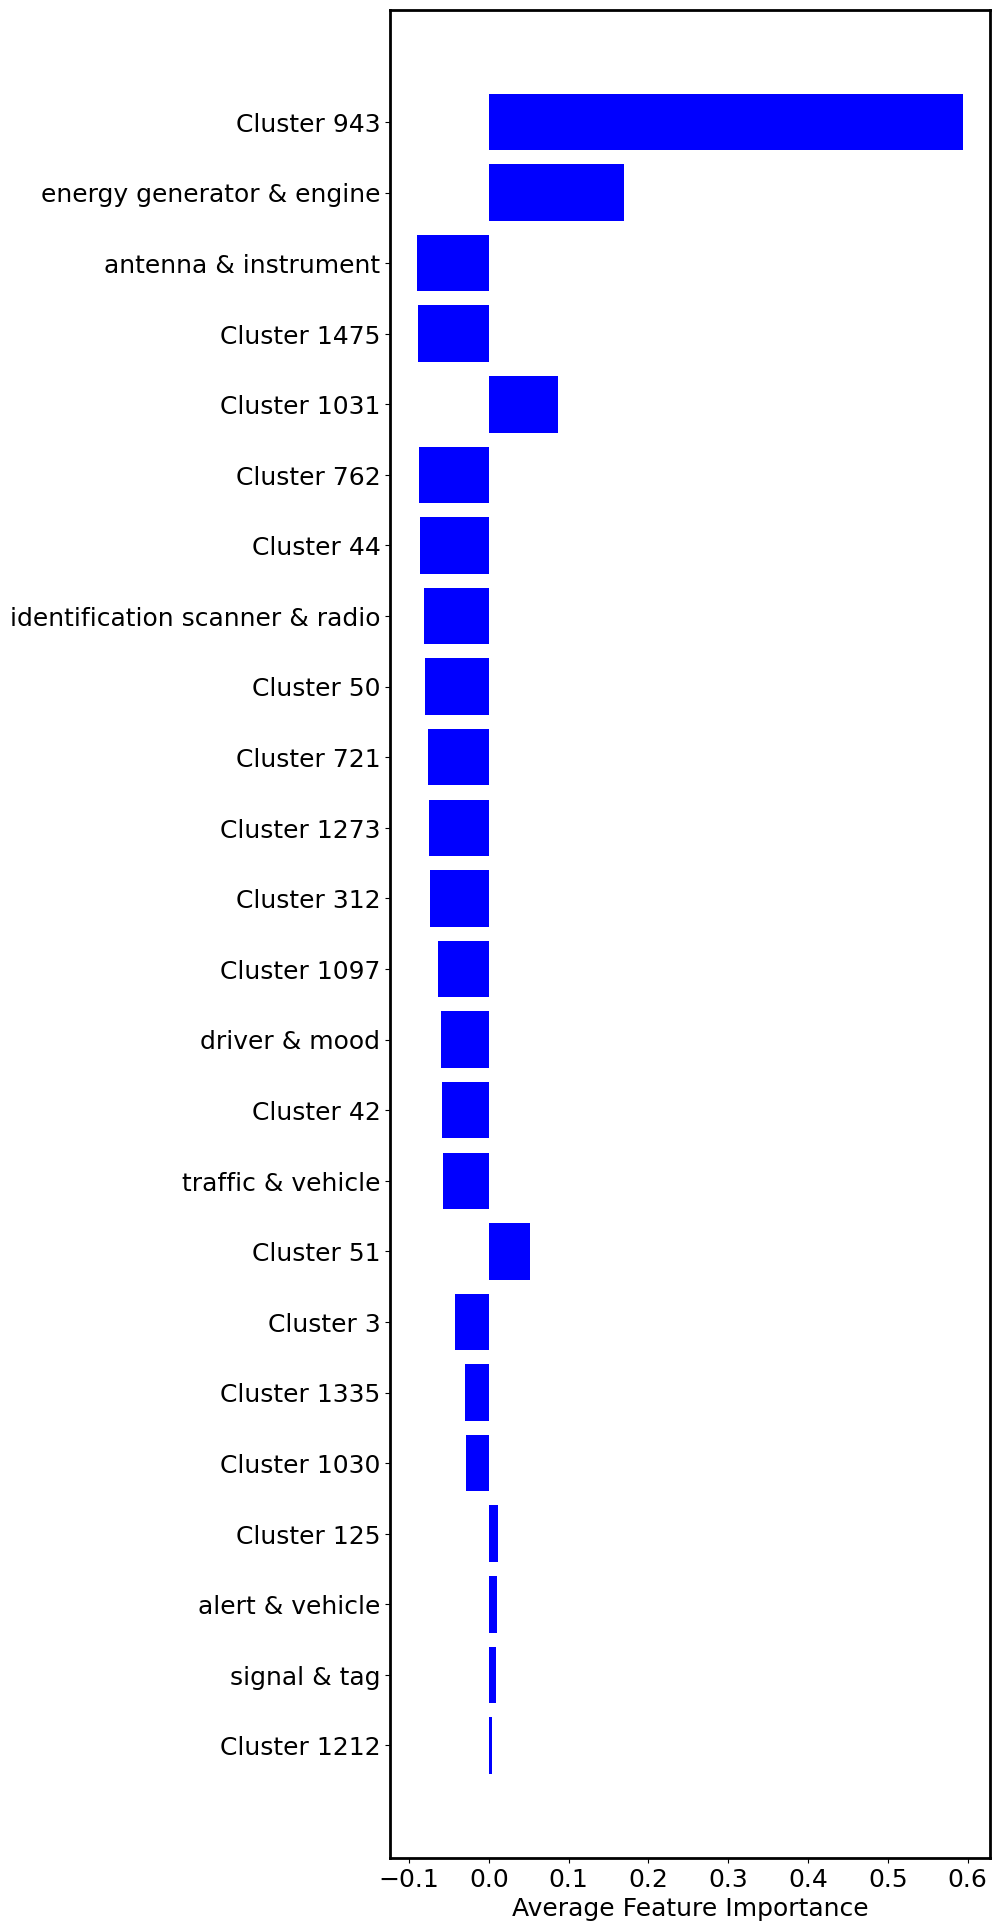

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2

time_periods = [(float(min(data['Year'])), 1990), (1991, 2008), (2009, 2016), (2017, float(max(data['Year'])))]

for (start, stop) in time_periods:
    imps = pd.read_csv(f'/kaggle/input/feature-importance/feature_importance_{start}_to_{stop}.csv')
    accepted_imps = imps[(imps['Decision']=='Accepted') & (imps['Features'].str.contains('\+') | imps['Features'].str.contains('cluster_'))]
    
    #prettify variable names
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('+', ' & ')
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('_', ' ')
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('scaled', '')
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('cluster', 'Cluster')
    
    accepted_imps_abs = accepted_imps.reindex(accepted_imps['Average Feature Importance'].abs().sort_values(ascending=False).index)#.head(10)
    
    # Dynamically set the figure height based on the number of features
    fig, ax = plt.subplots(figsize=(10, len(accepted_imps_abs)))  # Specify the figure size
    
    plt.subplots_adjust(left=0.3)  # Adjust the left margin
    plt.barh(accepted_imps_abs['Features'], accepted_imps_abs['Average Feature Importance'], color='blue')
    plt.xlabel('Average Feature Importance')
    ax.set_aspect('auto')  # Set a fixed aspect ratio
    plt.gca().invert_yaxis()
    
    # Save the plot to a file
    plt.savefig(f'feature_importance_{int(start)}_to_{int(stop)}.png', bbox_inches='tight')
    plt.show()  # Close the figure


In [16]:
#get all sentences for which co-occurrence was accepted as feature
import csv
import ast 

time_periods = [(float(min(data['Year'])), 1990), (1991, 2008), (2009, 2016), (2017, float(max(data['Year'])))] 
results = []
for (start, stop) in time_periods:
    

    df_time_period = df[(df['Year'] >= start) & (df['Year'] <= stop)] 


    tfidf_dummy = pd.read_csv(f'/kaggle/input/tfidf-dummy/tfidf_dummy_{start}_{stop}_maxdf0.5_tfidfperc99.csv').drop('Unnamed: 0', axis=1)

    with open(f'/kaggle/input/cluster-dict/cluster_dict{start}_{stop}.csv', 'r') as f:
        reader = csv.reader(f)
        cluster_dict = {int(rows[0]):ast.literal_eval(rows[1]) for rows in reader}
        print(len(cluster_dict))
    result = find_accepted_sentences(file= f'/kaggle/input/feature-importance/feature_importance_{start}_to_{stop}.csv', tfidf_dummy=tfidf_dummy, df_time_period=df_time_period.reset_index(drop=True), cluster_dict=cluster_dict)

    results.append(result) 

save_as_xlsx(results, filename='Accepted Co-Occurrences')

36
615
1217
1511


In [17]:
all_sheets = pd.read_excel('/kaggle/working/Accepted Co-Occurrences.xlsx', sheet_name=None)
all_sheets = list(all_sheets.values())

for i in range(4):
    print(all_sheets[i].shape)

(23, 6)
(41, 6)
(336, 6)
(378, 6)


In [18]:
#only take top x features per timeframe:
import csv
import ast 

keep_top_n = [2,3,8,12]
keep_indices = [range(2), range(3), list(range(7)),range(5)]#range(4)

time_periods = [(float(min(df['Year'])), 1990), (1991, 2008), (2009, 2016), (2017, float(max(df['Year'])))] 
results = []
for i, (start, stop) in enumerate(time_periods):
    

    df_time_period = df[(df['Year'] >= start) & (df['Year'] <= stop)] 


    tfidf_dummy = pd.read_csv(f'/kaggle/input/tfidf-dummy/tfidf_dummy_{start}_{stop}_maxdf0.5_tfidfperc99.csv').drop('Unnamed: 0', axis=1)

    with open(f'/kaggle/input/cluster-dict/cluster_dict{start}_{stop}.csv', 'r') as f:
        reader = csv.reader(f)
        cluster_dict = {int(rows[0]):ast.literal_eval(rows[1]) for rows in reader}
    #only keep top n features, based on average importance
    result = find_accepted_sentences(n=keep_indices[i], file= f'/kaggle/input/feature-importance/feature_importance_{start}_to_{stop}.csv', tfidf_dummy=tfidf_dummy, df_time_period=df_time_period.reset_index(drop=True), cluster_dict=cluster_dict)

    results.append(result) 

save_as_xlsx(results, filename='Important Co-Occurrences')

all_sheets = pd.read_excel('/kaggle/working/Important Co-Occurrences.xlsx', sheet_name=None)
all_sheets_list = list(all_sheets.values())
sheet_names = list(all_sheets.keys())

for i in range(4):
    print(all_sheets_list[i].shape)

(21, 6)
(24, 6)
(133, 6)
(66, 6)


In [19]:
for i in range(4):
    random.seed(0)
    sample = random.sample(range(all_sheets_list[i].shape[0]), int(np.ceil(all_sheets_list[i].shape[0]/10)))
    sample.sort()
    np.save(f'random_sample_{sheet_names[i]} (10% of data)', sample)
    print(sample)

[1, 12, 13]
[1, 12, 13]
[10, 35, 55, 66, 72, 77, 91, 98, 103, 107, 122, 124, 129, 130]
[5, 16, 31, 32, 49, 53, 61]


In [20]:
for i in range(4):
    print(np.load(f'random_sample_{sheet_names[i]} (10% of data).npy'))

[ 1 12 13]
[ 1 12 13]
[ 10  35  55  66  72  77  91  98 103 107 122 124 129 130]
[ 5 16 31 32 49 53 61]


In [21]:
sampled_sheets = {}

for i in range(4):
    indices = np.load(f'random_sample_{sheet_names[i]} (10% of data).npy')
    sampled_df = all_sheets_list[i].iloc[indices]
    
    # Store the sampled dataframe in the dictionary
    sampled_sheets[sheet_names[i]] = sampled_df

# Save the sampled dataframes back to an Excel file
with pd.ExcelWriter('/kaggle/working/Sampled Important Co-Occurrences.xlsx') as writer:
    for sheet_name, df in sampled_sheets.items():
        df.to_excel(writer, sheet_name=sheet_name)

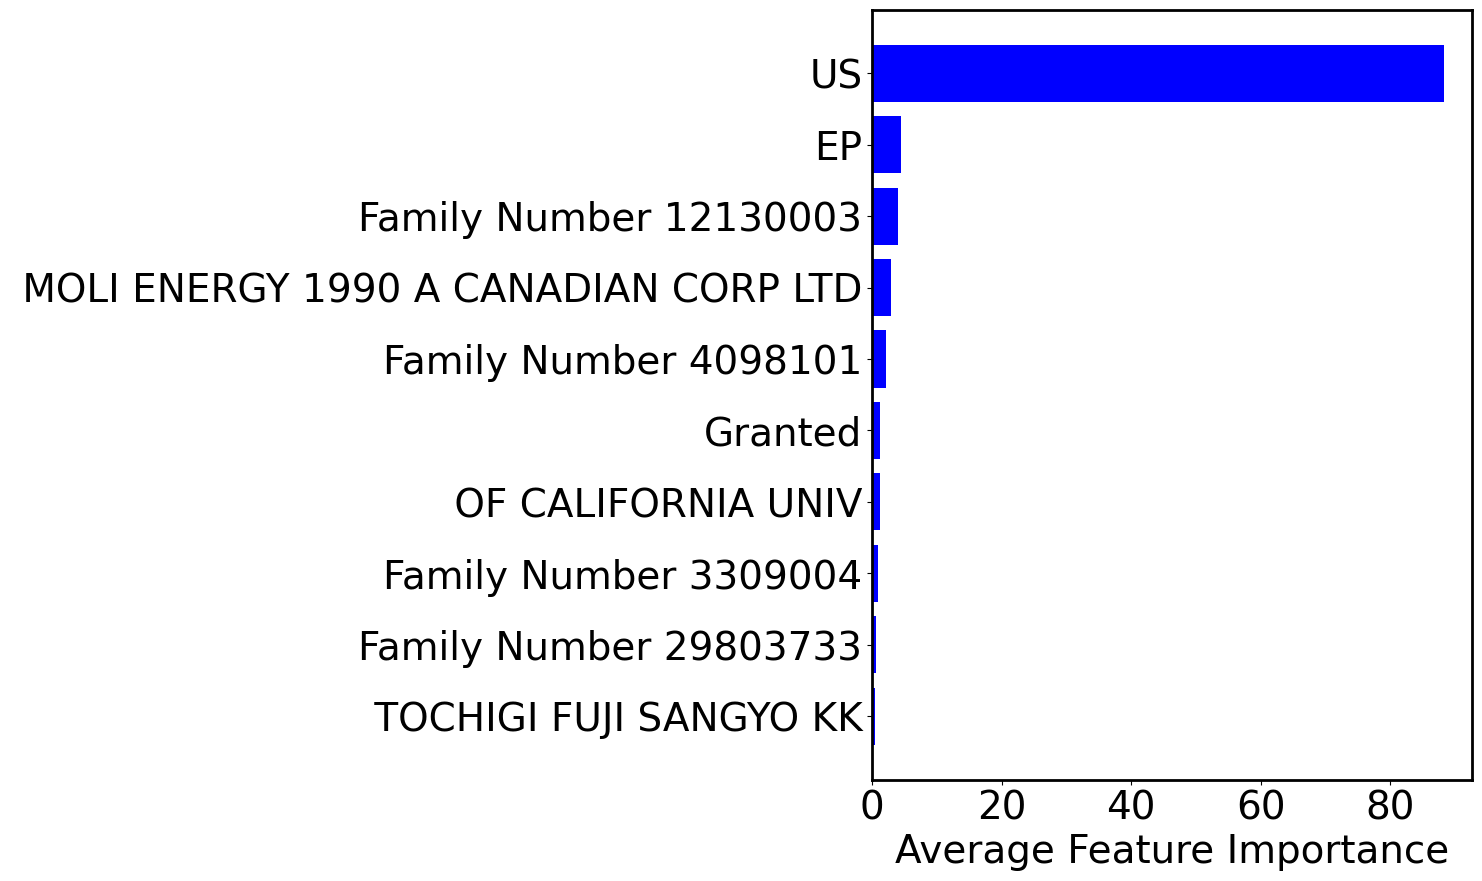

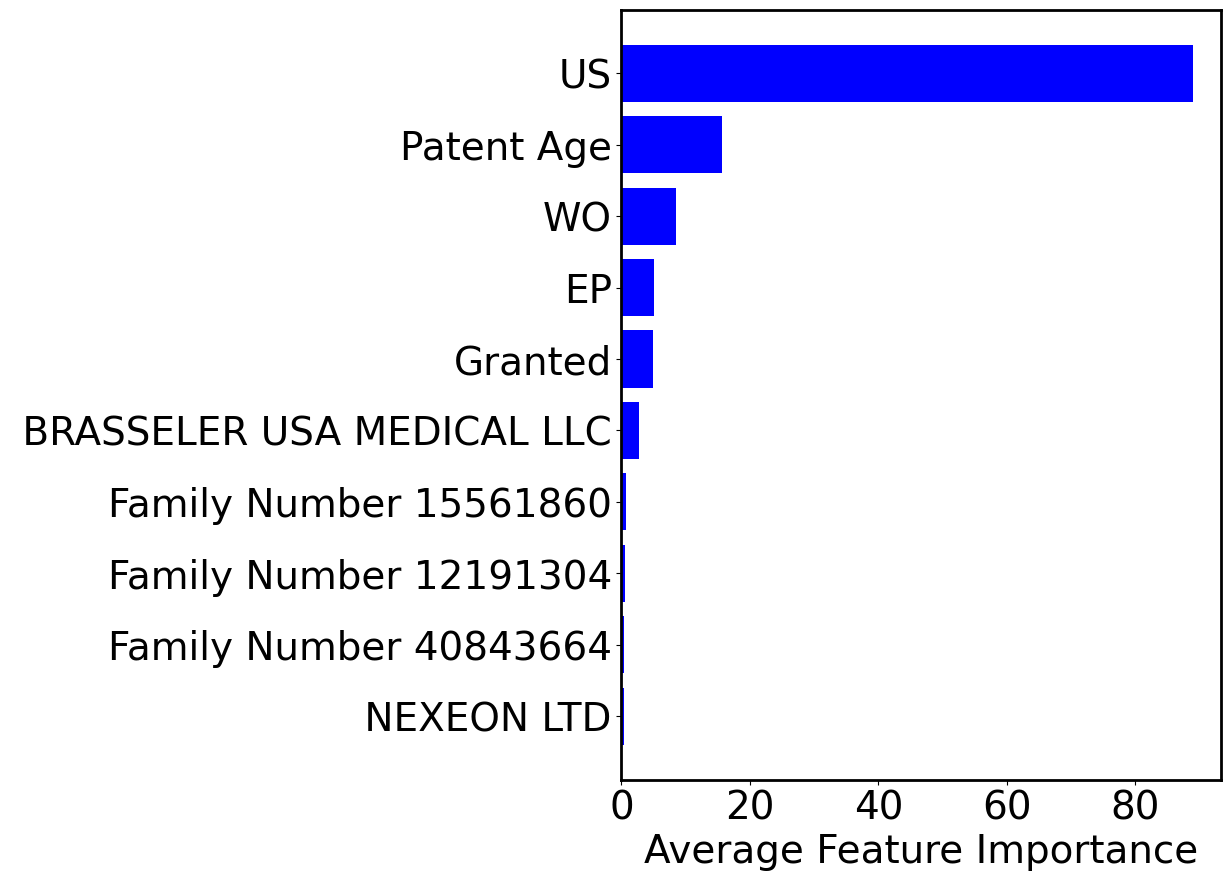

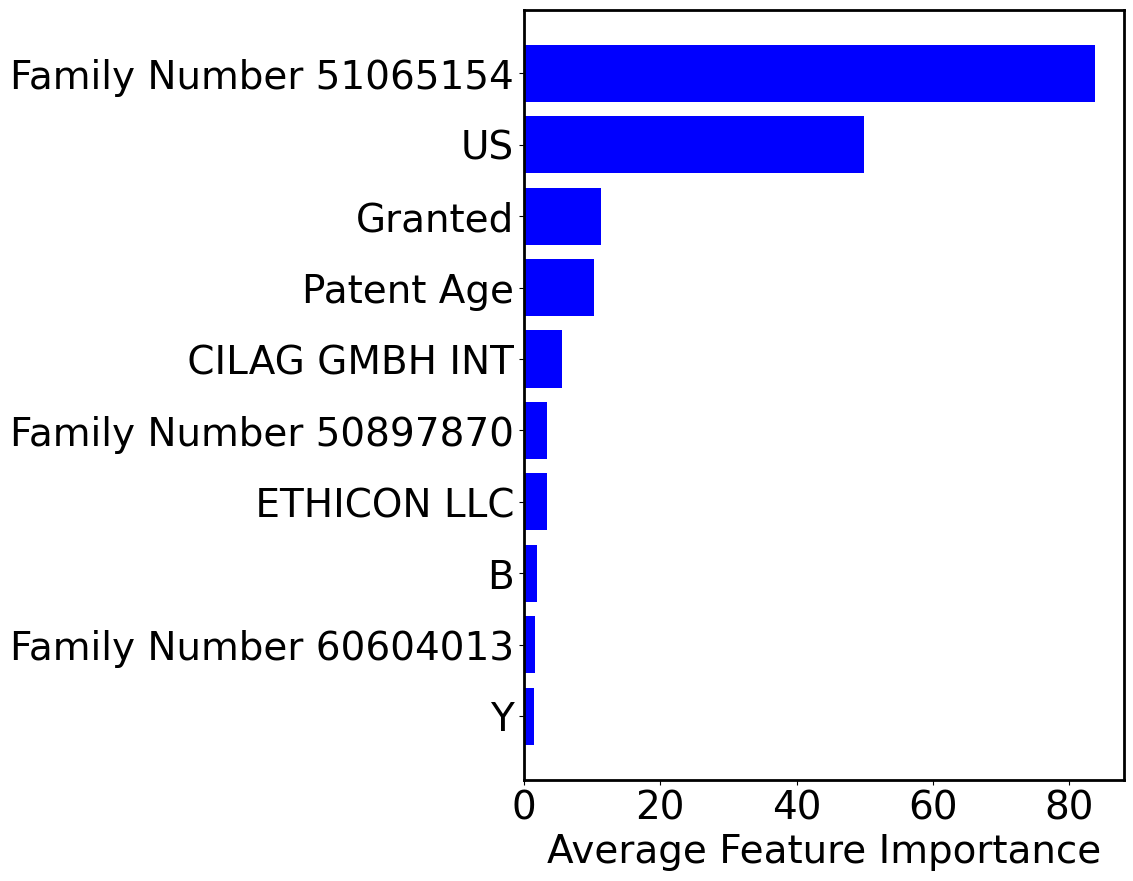

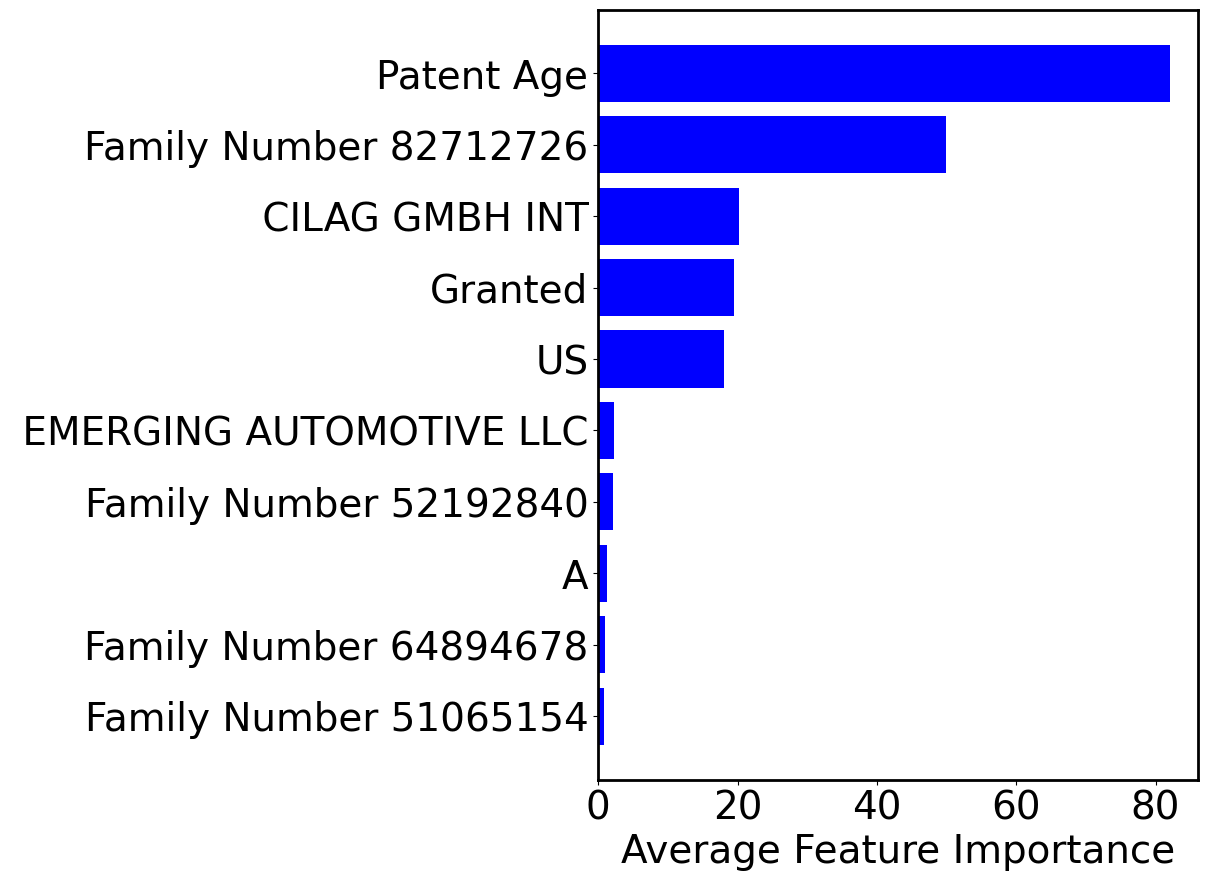

In [22]:
#plots for controls
import matplotlib.pyplot as plt
time_periods = [(float(min(data['Year'])), 1990), (1991, 2008), (2009, 2016), (2017, float(max(data['Year'])))] 

plt.rcParams['font.size'] = 28

for (start, stop) in time_periods:
    imps = pd.read_csv(f'/kaggle/input/feature-importance/feature_importance_{start}_to_{stop}.csv')
    accepted_imps = imps[(imps['Decision']=='Accepted') & ~(imps['Features'].str.contains('\+') | imps['Features'].str.contains('cluster_'))]
    #prettify variable names
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('Country.Code_', '')
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('Probable.Patent.Assignee', '')
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('.', ' ')
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('age_scaled', 'Age')
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('Grant_dummy', 'Granted')
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('_', ' ')
    
    accepted_imps_abs = accepted_imps.reindex(accepted_imps['Average Feature Importance'].abs().sort_values(ascending=False).index).head(10)
    
    # Dynamically set the figure height based on the number of features
    fig, ax = plt.subplots(figsize=(10, len(accepted_imps_abs)))  # Specify the figure size
    
    plt.subplots_adjust(left=0.3)  # Adjust the left margin
    plt.barh(accepted_imps_abs['Features'], accepted_imps_abs['Average Feature Importance'], color='blue')
    plt.xlabel('Average Feature Importance')
    ax.set_aspect('auto')  # Set a fixed aspect ratio
    #colors = ['tab:blue', 'tab:blue', 'red', 'tab:blue', 'tab:blue']
    plt.barh(accepted_imps_abs['Features'], accepted_imps_abs['Average Feature Importance'], color='blue')#color=colors)

    plt.gca().invert_yaxis()
    plt.savefig(f'top10_control_variables_{int(start)}_to_{int(stop)}.png', bbox_inches='tight')
    plt.show()


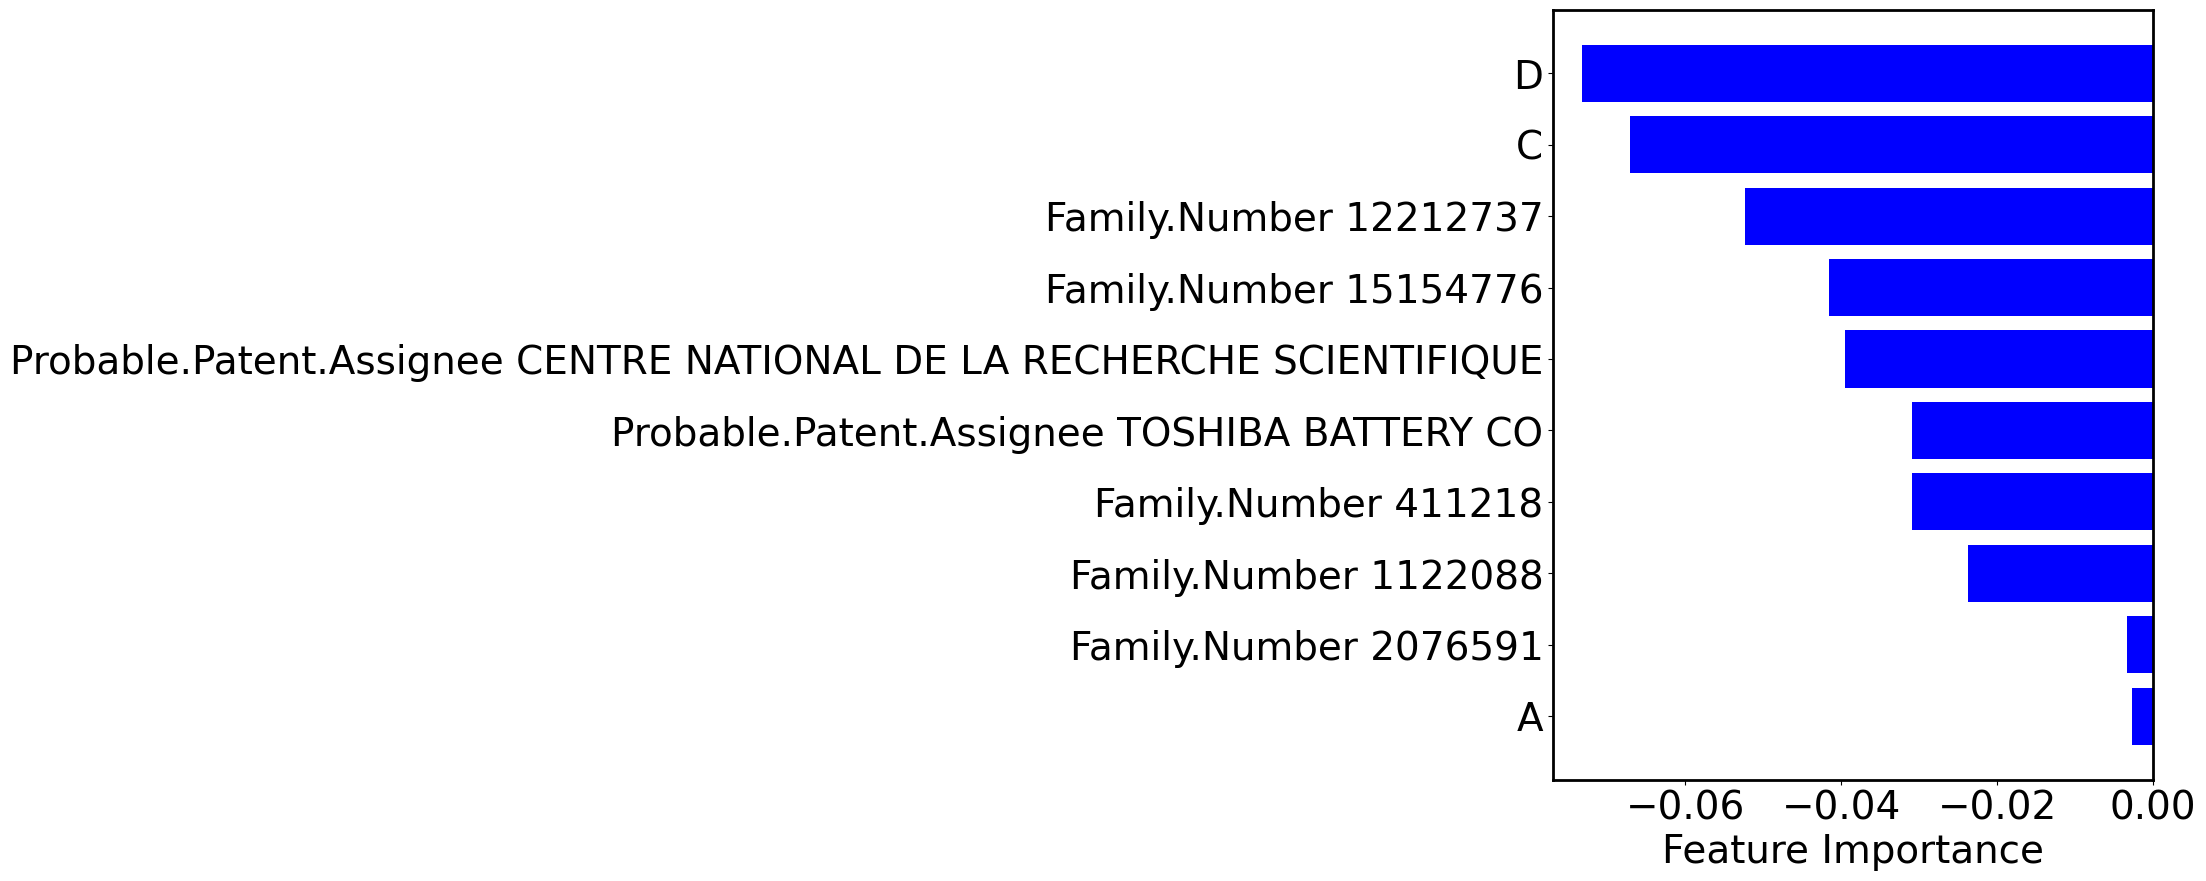

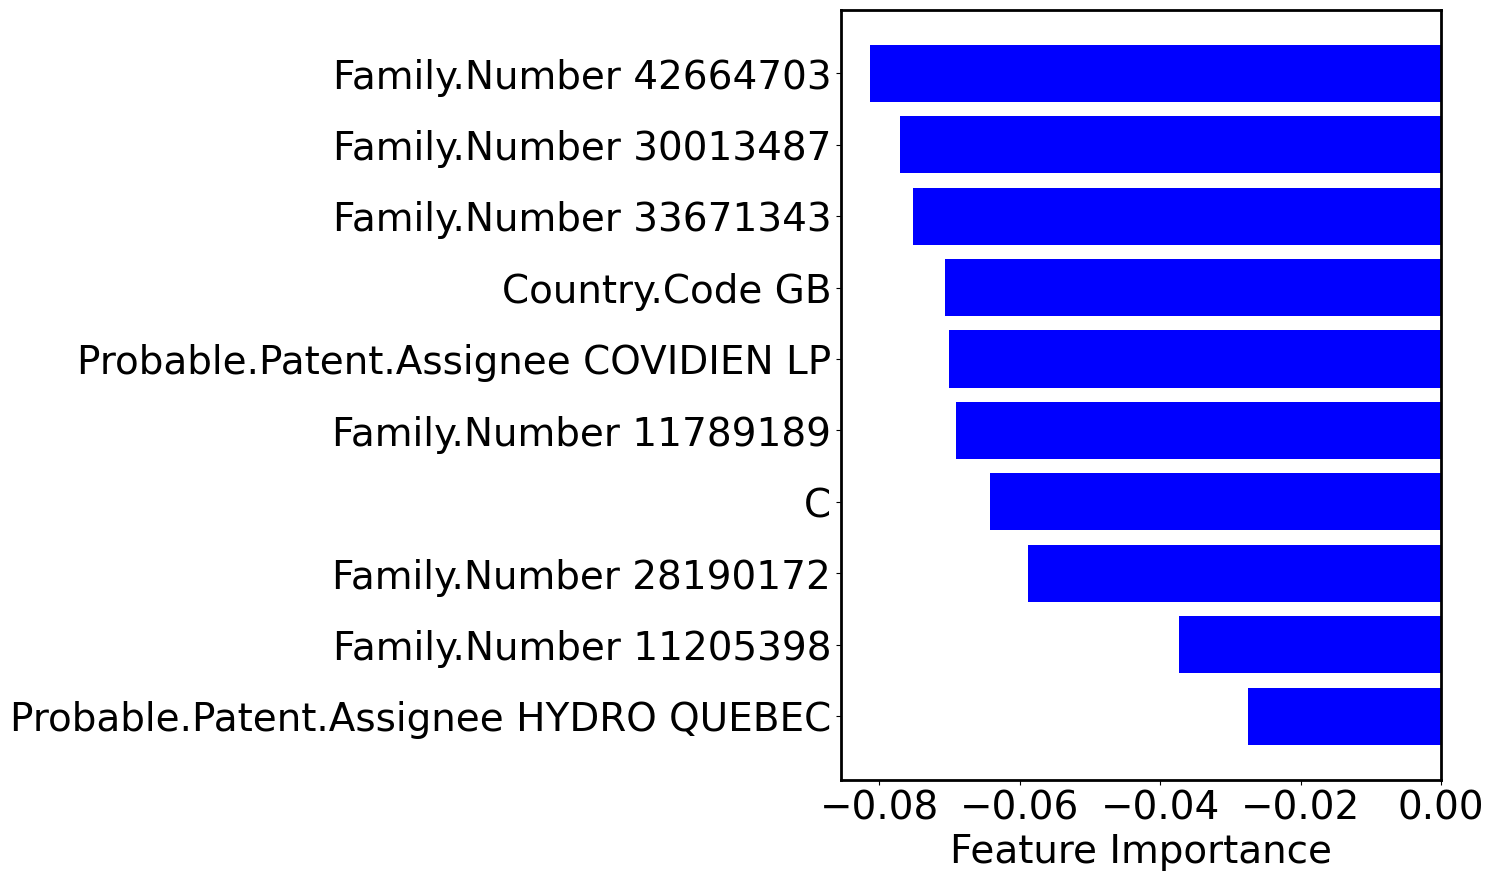

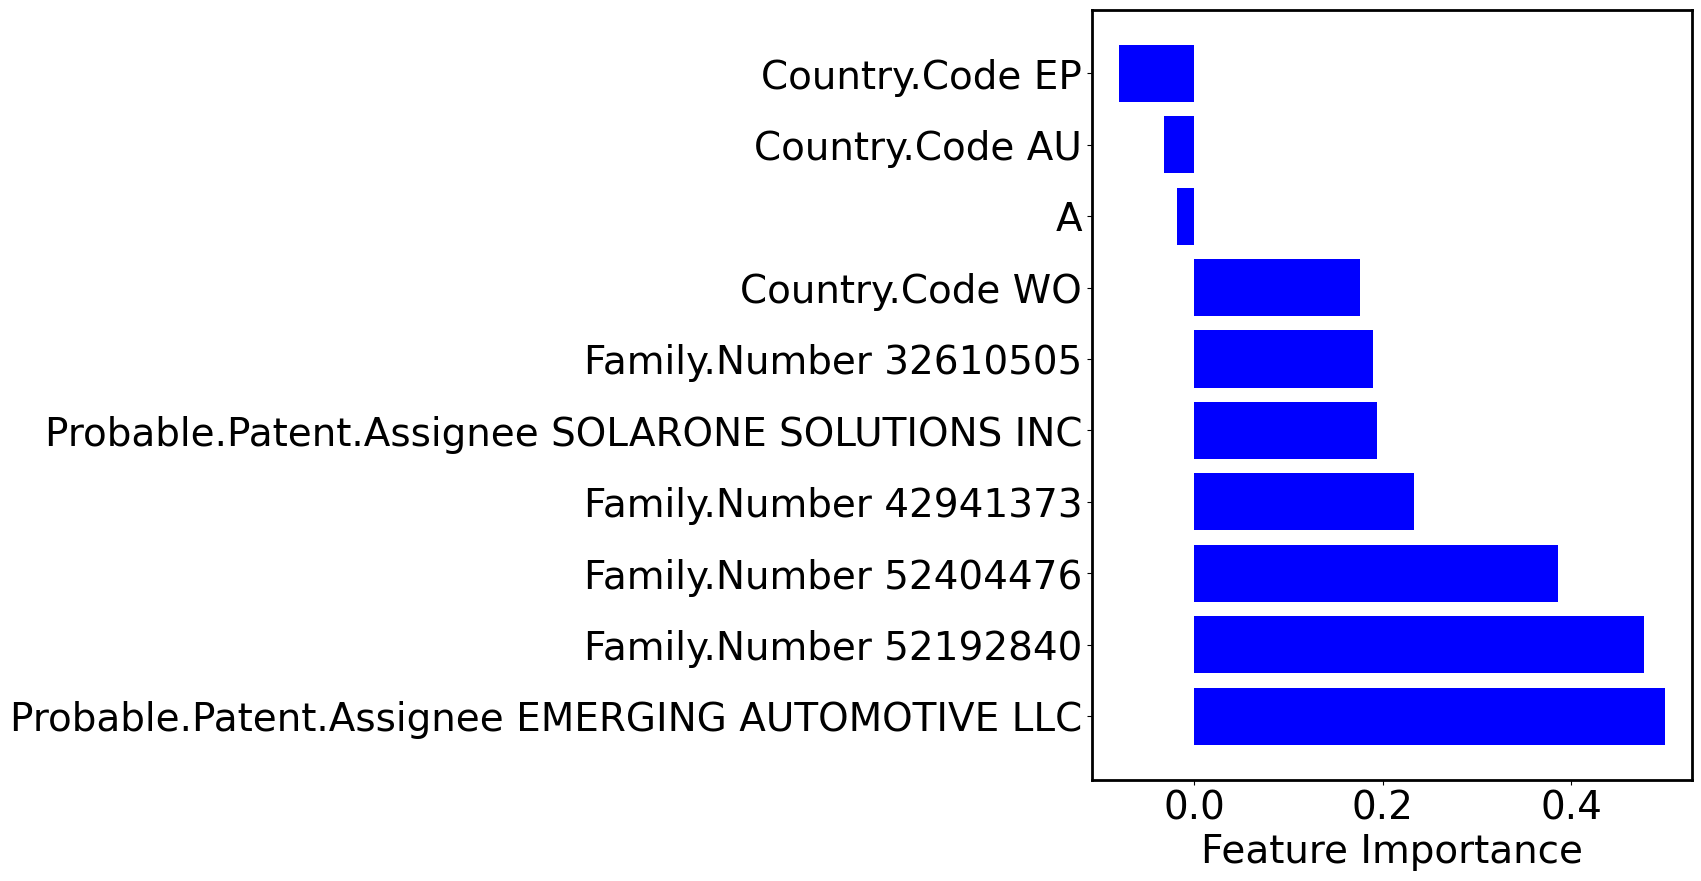

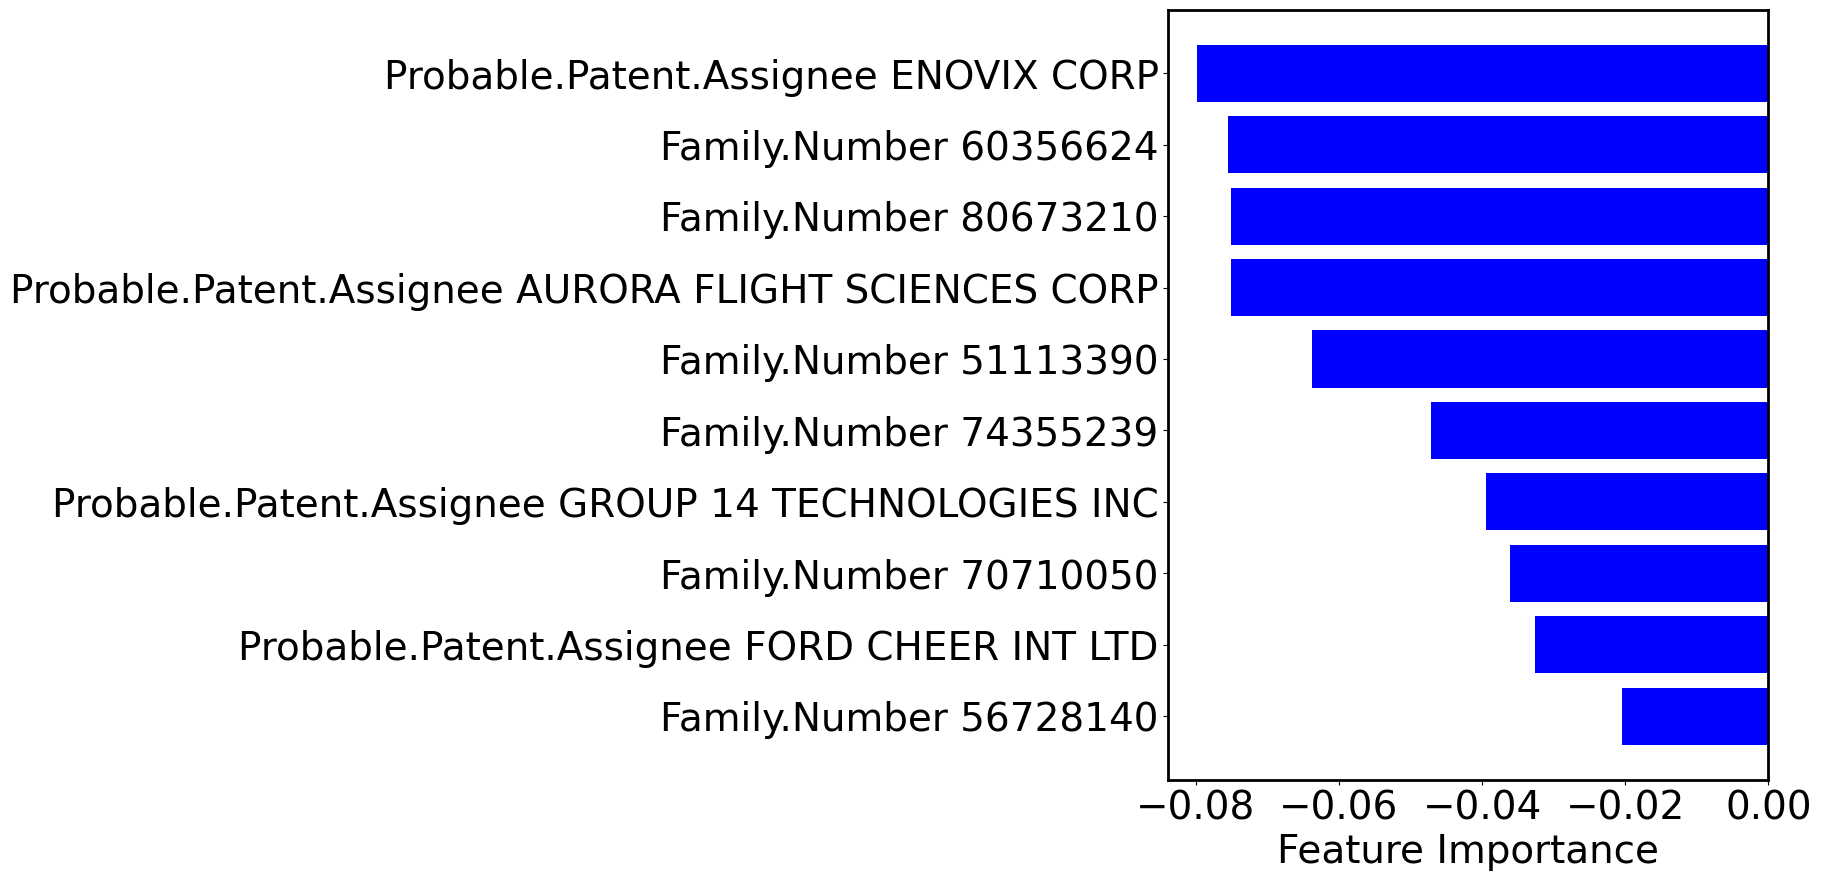

In [23]:
import matplotlib.pyplot as plt

time_periods = [(float(min(data['Year'])), 1990), (1991, 2008), (2009, 2016), (2017, float(max(data['Year'])))]

for (start, stop) in time_periods:
    imps = pd.read_csv(f'/kaggle/input/feature-importance/feature_importance_{start}_to_{stop}.csv')
    accepted_imps = imps[(imps['Decision']=='Accepted') & ~(imps['Features'].str.contains('\+') | imps['Features'].str.contains('cluster_'))]
    
    # Prettify variable names
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('+', ' & ')
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('_', ' ')
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('scaled', '')
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('cluster', 'Cluster')
    
    # Sort by 'Average Feature Importance' without taking the absolute value
    accepted_imps_sorted = accepted_imps.sort_values(by='Average Feature Importance').head(10)
    
    # Dynamically set the figure height based on the number of features
    fig, ax = plt.subplots(figsize=(10, len(accepted_imps_sorted)))
    
    plt.subplots_adjust(left=0.3)  # Adjust the left margin
    plt.barh(accepted_imps_sorted['Features'], accepted_imps_sorted['Average Feature Importance'], color='blue')
    plt.xlabel('Feature Importance')
    ax.set_aspect('auto')  # Set a fixed aspect ratio

    plt.gca().invert_yaxis()
    plt.show()


In [24]:
import csv
import ast

time_periods = [(float(min(data['Year'])), 1990), (1991, 2008), (2009, 2016), (2017, float(max(data['Year'])))]

cluster_dicts = {}

for (start, stop) in time_periods:
    with open(f'/kaggle/input/cluster-dict/cluster_dict{start}_{stop}.csv', 'r') as f:
        reader = csv.reader(f)
        cluster_dict = {int(rows[0]):ast.literal_eval(rows[1]) for rows in reader}
        cluster_dicts[f'{start}_{stop}'] = cluster_dict


In [25]:
cluster_dicts[f'{start}_{stop}'][0]

['deg ray diffraction+diffraction intensity deg',
 'conductor+deg ray diffraction',
 'deg+ray diffraction intensity',
 'diffraction intensity+intensity deg',
 'deg+diffraction intensity']

In [26]:
import csv
import ast
import pandas as pd

time_periods = [(float(min(data['Year'])), 1990), (1991, 2008), (2009, 2016), (2017, float(max(data['Year'])))]

cluster_dicts = {}
important_clusters = {}

for i, (start, stop) in enumerate(time_periods):
    with open(f'/kaggle/input/cluster-dict/cluster_dict{start}_{stop}.csv', 'r') as f:
        reader = csv.reader(f)
        cluster_dict = {int(rows[0]):ast.literal_eval(rows[1]) for rows in reader}
        cluster_dicts[f'{start}_{stop}'] = cluster_dict

    imps = pd.read_csv(f'/kaggle/input/feature-importance/feature_importance_{start}_to_{stop}.csv')
    accepted_imps = imps[(imps['Decision']=='Accepted') & (imps['Features'].str.contains('\+') | imps['Features'].str.contains('cluster_'))]
    
    # Sort by absolute 'Average Feature Importance' and select top 10
    accepted_imps_abs = accepted_imps.reindex(accepted_imps['Average Feature Importance'].abs().sort_values(ascending=False).index).head(keep_top_n[i])
    
    # Get the relevant clusters for each time period
    relevant_clusters = [feature for feature in accepted_imps_abs['Features'] if 'cluster' in feature]
    important_clusters[f'{start}_{stop}'] = {cluster: cluster_dict[int(cluster.split('_')[-1])] for cluster in relevant_clusters}

print(important_clusters)


{'1920.0_1990': {'cluster_25': ['carrier+substance', 'cavity+insert', 'lid+material pin', 'member+rib', 'organophilic group+solution', 'organophilic+solution', 'group+organophilic', 'dioxide+heat mixture', 'accumulator+sulphate']}, '1991_2008': {'cluster_221': ['pillar+silicon substrate', 'pillar+substrate', 'silicon+substrate', 'cathode material metal+metal oxide formula', 'cathode material metal+material metal oxide']}, '2009_2016': {'cluster_801': ['cur+dis', 'heat exchanger+segment', 'jaw+stroke'], 'cluster_576': ['power source+source power', 'core+substrate', 'filter capacitor+port', 'fluorine+phosphorus atom molecule', 'attachment layer+sticker', 'output fluctuation+power'], 'cluster_640': ['instrument+transducer', 'bus bar+portion', 'filler+paste layer', 'crystal grain+grain particle', 'conductivity case+heat control pouch', 'layer stack+pad'], 'cluster_232': ['instrument+power', 'mandrel+portion portion', 'grouping+stud', 'fiber layer+melting point'], 'cluster_214': ['power+sou

In [27]:
cluster_names = {
    '1920.0_1990': {
        'cluster_25': 'Chemical and Material Composition' 
    },
    '1991_2008': {
        'cluster_221': 'Silicon Substrate'
    },
    '2009_2016': {
        'cluster_801': 'Heat Exchanger',
        'cluster_576': 'Power Source',
        'cluster_640': 'Transducer',
        'cluster_232': 'Power Instruments',
        'cluster_214': 'Power Source',
        'cluster_320': 'Fuse Terminal',
        'cluster_360': 'Power Source'
    },
    '2017_2023.0': {
        'cluster_943': 'Power Supply',
        'cluster_1475': 'Silicon Polymer',
        'cluster_1031': 'Power Generation',
        'cluster_762': 'Heat Transfer',
        'cluster_44': 'Polymer Electrolyte',
        'cluster_50': 'Alignment Apparatus',
        'cluster_721': 'Resin Layer',
        'cluster_1273': 'Heat Dissipation',
        'cluster_312': 'Coating Layer'
    }
}


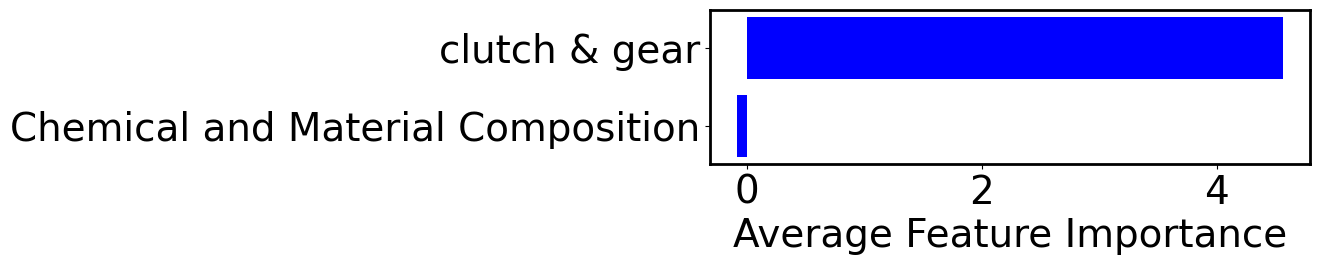

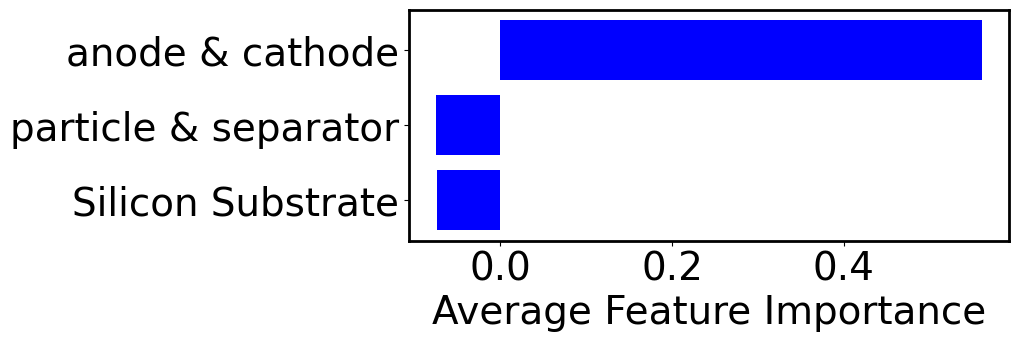

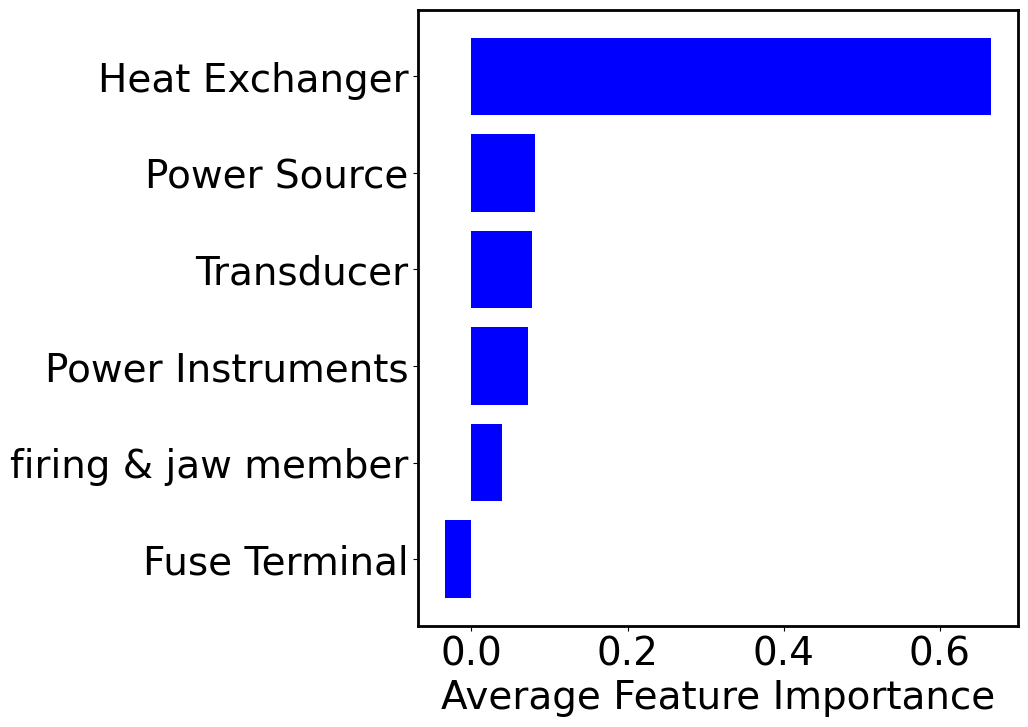

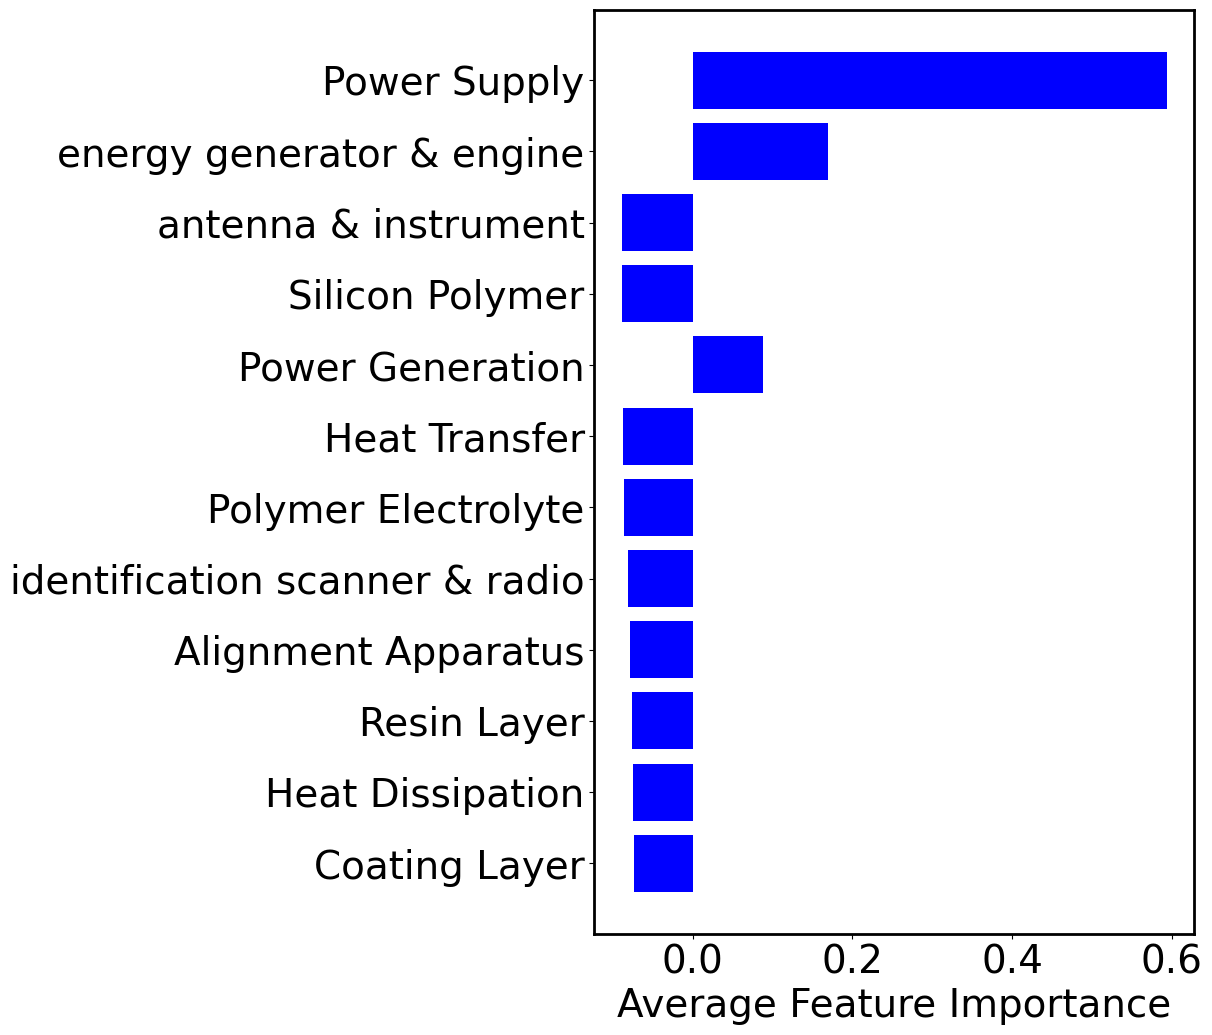

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['font.size'] = 28
plt.rcParams['axes.linewidth'] = 2

cluster_names = {
    '1920.0_1990': {
        'cluster_25': 'Chemical and Material Composition' 
    },
    '1991_2008': {
        'cluster_221': 'Silicon Substrate'
    },
    '2009_2016': {
        'cluster_801': 'Heat Exchanger',
        'cluster_576': 'Power Source',
        'cluster_640': 'Transducer',
        'cluster_232': 'Power Instruments',
        'cluster_214': 'Power Source',
        'cluster_320': 'Fuse Terminal',
        'cluster_360': 'Power Source'
    },
    '2017_2023.0': {
        'cluster_943': 'Power Supply',
        'cluster_1475': 'Silicon Polymer',
        'cluster_1031': 'Power Generation',
        'cluster_762': 'Heat Transfer',
        'cluster_44': 'Polymer Electrolyte',
        'cluster_50': 'Alignment Apparatus',
        'cluster_721': 'Resin Layer',
        'cluster_1273': 'Heat Dissipation',
        'cluster_312': 'Coating Layer'
    }
}

time_periods = [(float(min(data['Year'])), 1990), (1991, 2008), (2009, 2016), (2017, float(max(data['Year'])))]

for i, (start, stop) in enumerate(time_periods):
    imps = pd.read_csv(f'/kaggle/input/feature-importance/feature_importance_{start}_to_{stop}.csv')
    accepted_imps = imps[(imps['Decision']=='Accepted') & (imps['Features'].str.contains('\+') | imps['Features'].str.contains('cluster_'))].copy()  # Create a copy of the DataFrame slice
    
    # Replace cluster_ variables with their corresponding cluster names
    accepted_imps.replace(cluster_names[str(start)+'_'+str(stop)], inplace=True)
    
    #prettify variable names
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('+', ' & ')
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('_', ' ')
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('scaled', '')
    
    accepted_imps_abs = accepted_imps.reindex(accepted_imps['Average Feature Importance'].abs().sort_values(ascending=False).index).head(keep_top_n[i])
    
    # Dynamically set the figure height based on the number of features
    fig, ax = plt.subplots(figsize=(10, len(accepted_imps_abs)))  # Specify the figure size
    
    plt.subplots_adjust(left=0.3)  # Adjust the left margin
    plt.barh(accepted_imps_abs['Features'], accepted_imps_abs['Average Feature Importance'], color='blue')
    plt.xlabel('Average Feature Importance')
    ax.set_aspect('auto')  # Set a fixed aspect ratio
    plt.gca().invert_yaxis()
    #plt.title(f'{int(start)}-{int(stop)}')
    
    # Save the plot to a file
    plt.savefig(f'feature_importance_{int(start)}_to_{int(stop)}.png', bbox_inches='tight')
    plt.show()  # Close the figure


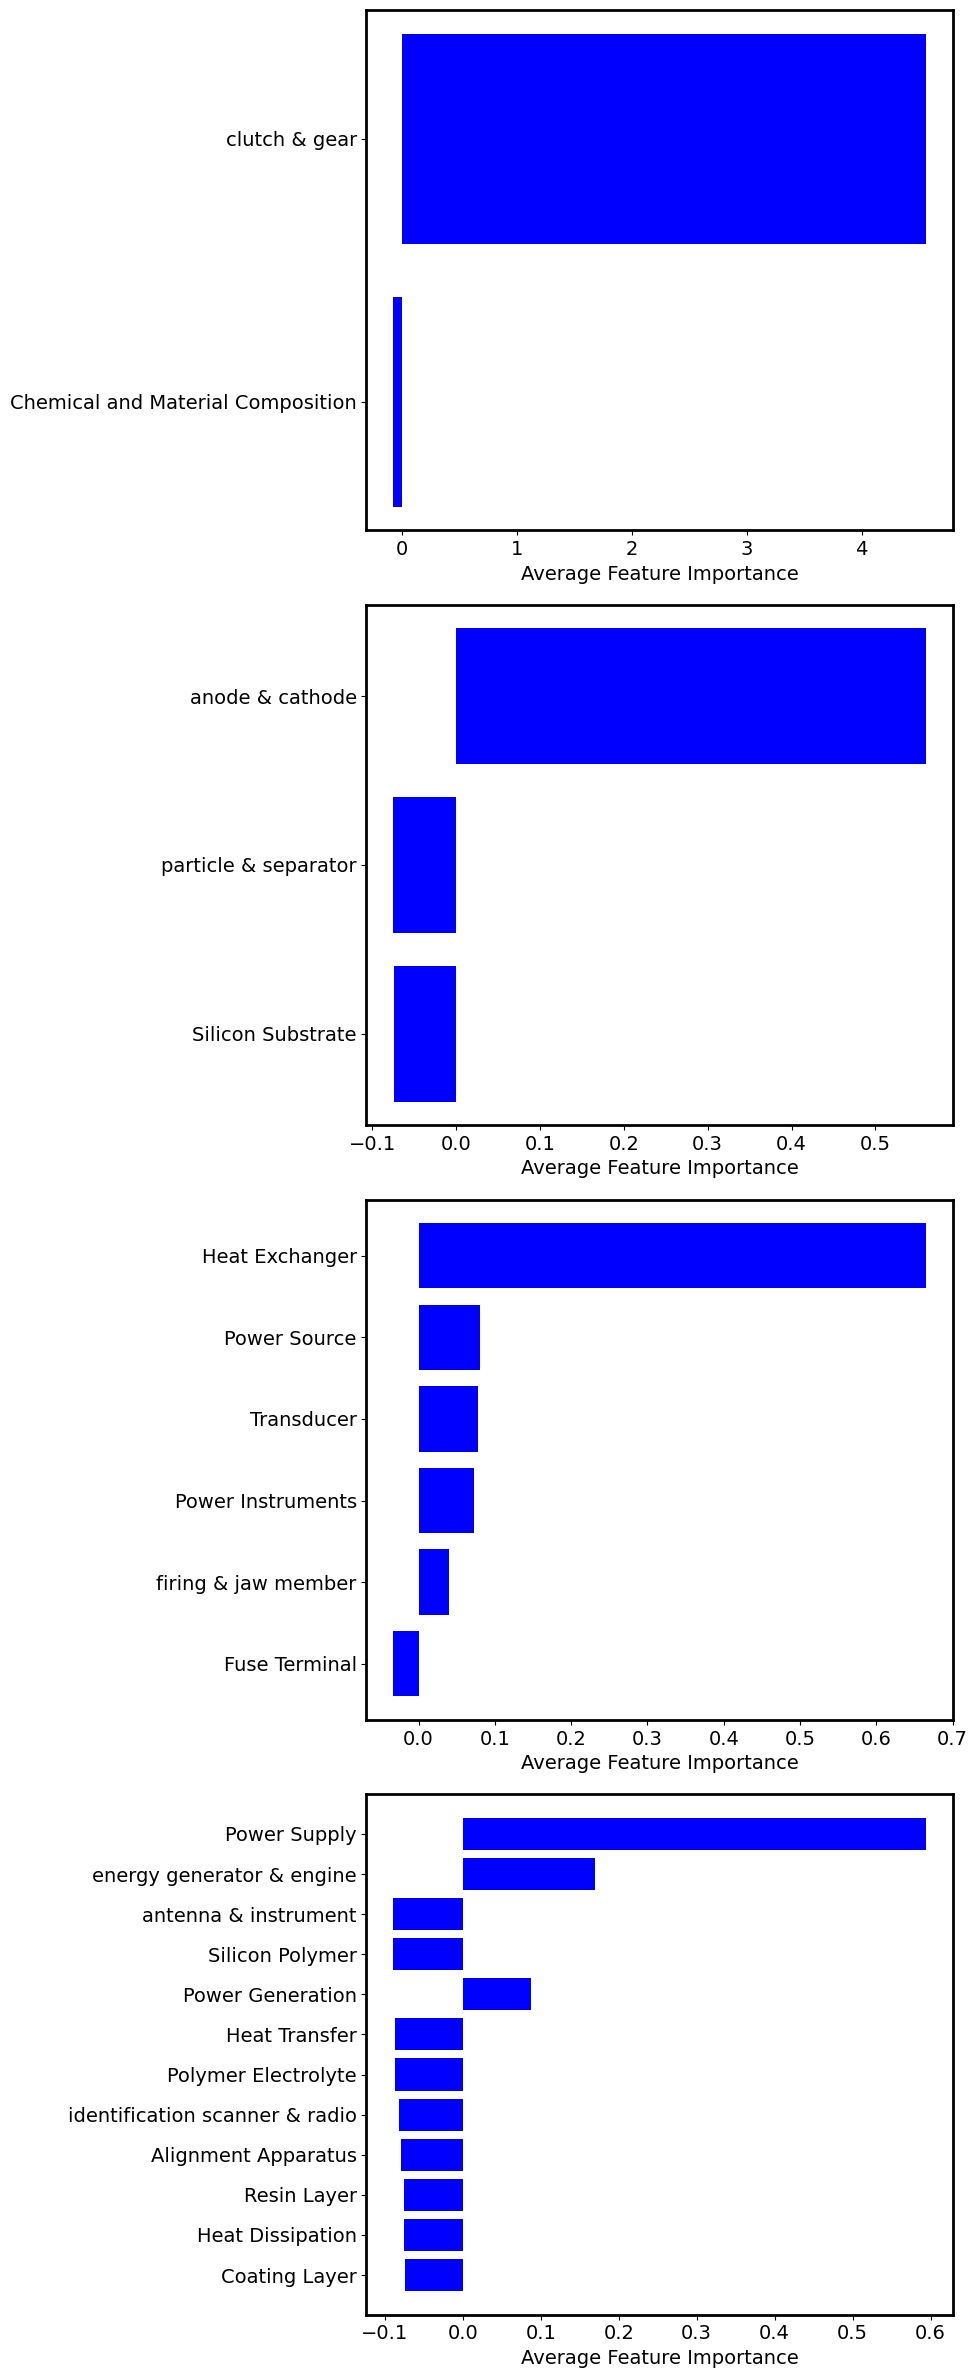

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 2

cluster_names = {
    '1920.0_1990': {
        'cluster_25': 'Chemical and Material Composition' 
    },
    '1991_2008': {
        'cluster_221': 'Silicon Substrate'
    },
    '2009_2016': {
        'cluster_801': 'Heat Exchanger',
        'cluster_576': 'Power Source',
        'cluster_640': 'Transducer',
        'cluster_232': 'Power Instruments',
        'cluster_214': 'Power Source',
        'cluster_320': 'Fuse Terminal',
        'cluster_360': 'Power Source'
    },
    '2017_2023.0': {
        'cluster_943': 'Power Supply',
        'cluster_1475': 'Silicon Polymer',
        'cluster_1031': 'Power Generation',
        'cluster_762': 'Heat Transfer',
        'cluster_44': 'Polymer Electrolyte',
        'cluster_50': 'Alignment Apparatus',
        'cluster_721': 'Resin Layer',
        'cluster_1273': 'Heat Dissipation',
        'cluster_312': 'Coating Layer'
    }
}

time_periods = [(float(min(data['Year'])), 1990), (1991, 2008), (2009, 2016), (2017, float(max(data['Year'])))]

# Create a single figure
fig, axs = plt.subplots(len(time_periods), 1, figsize=(10, len(time_periods)*6))

for i, (start, stop) in enumerate(time_periods):
    imps = pd.read_csv(f'/kaggle/input/feature-importance/feature_importance_{start}_to_{stop}.csv')
    accepted_imps = imps[(imps['Decision']=='Accepted') & (imps['Features'].str.contains('\+') | imps['Features'].str.contains('cluster_'))].copy()  # Create a copy of the DataFrame slice
    
    # Replace cluster_ variables with their corresponding cluster names
    accepted_imps.replace(cluster_names[str(start)+'_'+str(stop)], inplace=True)
    
    #prettify variable names
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('+', ' & ')
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('_', ' ')
    accepted_imps.loc[:,'Features'] = accepted_imps.loc[:,'Features'].str.replace('scaled', '')
    
    accepted_imps_abs = accepted_imps.reindex(accepted_imps['Average Feature Importance'].abs().sort_values(ascending=False).index).head(keep_top_n[i])
    
    # Use the current axes for plotting
    ax = axs[i]
    
    ax.barh(accepted_imps_abs['Features'], accepted_imps_abs['Average Feature Importance'], color='blue')
    ax.set_xlabel('Average Feature Importance')
    ax.set_aspect('auto')  # Set a fixed aspect ratio
    ax.invert_yaxis()
    #ax.set_title(f'{int(start)}-{int(stop)}')

# Save the plot to a file
plt.tight_layout()
plt.savefig('feature_importance.png', bbox_inches='tight')
plt.show()


In [ ]:
cluster_df = pd.DataFrame([(key, var, val) for key, dic in important_clusters.items() for var, val in dic.items()], columns=['Time Period', 'Cluster', 'Features'])
for i, feats in enumerate(cluster_df['Features']):
    
    print(f'{cluster_df.Cluster[i]}: {feats}')
    

In [ ]:
cluster_df = pd.DataFrame([(key, var, val) for key, dic in important_clusters.items() for var, val in dic.items()], columns=['Time Period', 'Cluster', 'Features'])

# Replace 'Cluster' column values with their corresponding names from 'cluster_names' dictionary
for period, clusters in cluster_names.items():
    for cluster, name in clusters.items():
        cluster_df.loc[(cluster_df['Time Period'] == period) & (cluster_df['Cluster'] == cluster), 'Cluster'] = name

# Initialize variable to keep track of the current time period
current_period = None

for i, feats in enumerate(cluster_df['Features']):
    # If the time period has changed, print it
    if cluster_df['Time Period'][i] != current_period:
        current_period = cluster_df['Time Period'][i]
        print(f'\nTime Period: {current_period}\n')

    print(f'{cluster_df.Cluster[i]}: {feats}')


In [ ]:
data.loc[(data['Family.Number'] == 51065154) & (data['Year'].between(2009, 2016)), ['Title','Number.of.Forward.Citations']].sort_values(by='Number.of.Forward.Citations', ascending=False).head(20)


In [ ]:
data.loc[(data['Family.Number'] == 82712726) & (data['Year'].between(2017, 2023)), ['Title','Number.of.Forward.Citations']].sort_values(by='Number.of.Forward.Citations', ascending=False).head(20)


In [ ]:
data.loc[(data['Family.Number'] == 82712726) & (data['Year'].between(2017, 2023)), 'Title'].head(20)
